# Parametrization of axis-symmetric bubbles shapes - simple shapes

Four bubbles are investigated:
- bubbles in aqueous sugar solutions (Bhaga & Weber 1981)
    - spherical cap (closed wake) $Eo=115$, $Mo=4.63\times 10^{-3}$, $Ga^\prime = 135$
- small bubbles in water at 20°C, $Mo=2.5728\times 10^{-11}$
    - $d_{eq}=1.0~mm$ corresponding to $Eo=0.1346$, $Ga^\prime = 98.672$
    - $d_{eq}=1.4~mm$ corresponding to $Eo=0.2638$, $Ga^\prime = 163.45$
    - $d_{eq}=1.8~mm$ corresponding to $Eo=0.4361$, $Ga^\prime = 238.29$
    
The goal is to parametrize the bubbles shapes and then to export the shape to a geometry file that can be used by one of the standard OpenFOAM meshers. Star-shaped bubbles are described as spatially varying radius. Itersections of the piecewise linear interface reconstruction with the underlying background mesh are called *PLIC points* hereafter.

The main steps are:
1. select time instances and select corresponding iteration/bubble center/PLIC points
2. read PLIC points from disk and convert them to a polar coordinate system with the orgin being the (geometrical) bubble center
3. train a neural network to learn a representation of the shape
4. use the network to create a 2D STL file

## Load facets for given time instances

In [13]:
import copy
import glob
import helper_module as hm
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition, mark_inset
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import torch

%matplotlib inline


data_path = "../data/"
names = ["bhaga_03_l16", "water_01_l16", "water_03_l16", "water_05_l16"]
times = [30, 12, 14, 14]

cases = [data_path + name for name in names]

for i, case in enumerate(cases):
    print(i, case, times[i])

0 ../data/bhaga_03_l16 30
1 ../data/water_01_l16 12
2 ../data/water_03_l16 14
3 ../data/water_05_l16 14


In [14]:
all_facets = {}
for i, case in enumerate(cases):
    log_path = case + "/log." + names[i] + ".csv"
    log = hm.Logfile(log_path)
    log.read_logfile(usecols=['time', 'x'])
    row = log.find_closest("time", times[i])
    plic_path = case + "/plic_clean/plic_{:06d}.pkl".format(row.index.values[0]*10)
    all_facets[names[i]] = hm.FacetCollection2D(plic_path, [0, row.x.values[0]], True)

Successfully read file ../data/bhaga_03_l16/log.bhaga_03_l16.csv
Successfully read file ../data/bhaga_03_l16/plic_clean/plic_089590.pkl
Successfully read file ../data/water_01_l16/log.water_01_l16.csv
Successfully read file ../data/water_01_l16/plic_clean/plic_1045900.pkl
Successfully read file ../data/water_03_l16/log.water_03_l16.csv
Successfully read file ../data/water_03_l16/plic_clean/plic_871610.pkl
Successfully read file ../data/water_05_l16/log.water_05_l16.csv
Successfully read file ../data/water_05_l16/plic_clean/plic_677920.pkl


## Plot facets in polar coordinates

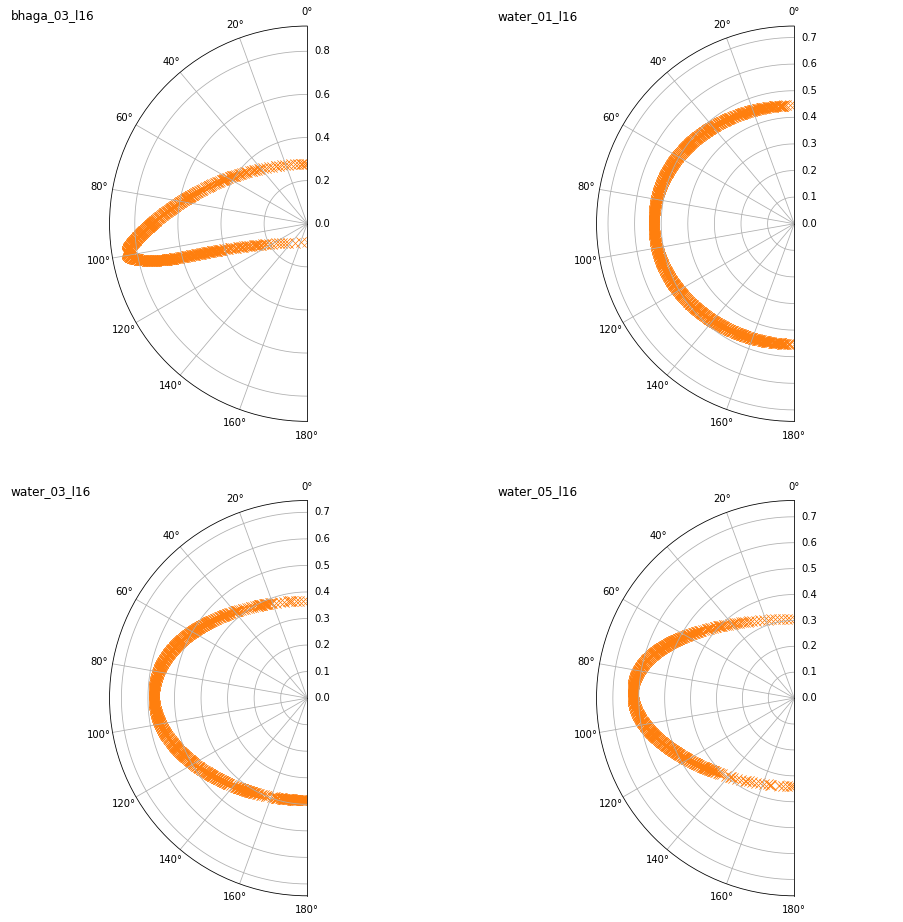

In [16]:
rc('text', usetex=False)
fig, axarr = plt.subplots(2, 2, figsize=(hm.figure_width, 16), subplot_kw=dict(projection='polar'))

idt = [(i, j) for i in [0, 1] for j in [0, 1]]

for i, name in enumerate(names):
    row, col = idt[i]
    rad, phi = all_facets[name].get_facets(polar=True)
    axarr[row, col].scatter(phi, rad, marker="x", color="C1", s=100, lw=0.5)
    axarr[row, col].set_theta_zero_location("N")
    axarr[row, col].set_xlim(0.0, np.pi)
    axarr[row, col].set_title(name, loc='left')

## Approximate shapes

In [97]:
def training_loop(model, path, x_train, y_train, epochs, l_rate):
    """Optimize the weights of a given MLP.
    
    Parameters
    ----------
    model - SimpleMLP : model to optimize
    path - String : path to save best model weights
    x_train - array-like : feature vector of dimension [n_samples, n_features]
    y_train - array-like : label vector of dimension [n_samples, n_features]
    epochs - Integer : number of epochs to train
    l_rate - Float : learning rate
    
    Returns
    -------
    history - List : loss developments over epochs
    model - SimpleMLP : opimized model in evaluation mode
    
    """
    x_order = np.argsort(x_train)
    x_sorted = x_train[x_order]
    y_sorted = y_train[x_order]
    penalty = np.ones(x_sorted.shape[0])
    penalty = np.where((x_sorted < 0.5) | (x_sorted > np.pi-0.5), 10, penalty)
    print(penalty[:20], penalty[-20:])
    #penalty[:10] = 10
    #penalty[-10:] = 10
    x_tensor = torch.from_numpy(x_sorted.astype(np.float64)).unsqueeze_(-1)
    y_tensor = torch.from_numpy(y_sorted.astype(np.float64))
    p_tensor = torch.from_numpy(penalty.astype(np.float64))
    zero = torch.zeros(y_tensor.shape[0])
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l_rate)

    best_loss = 1.0E5
    train_loss = []

    for e in range(1, epochs+1):
        optimizer.zero_grad()
        output = model.forward(x_tensor)
        diff = (output.squeeze(dim=1) - y_tensor) * p_tensor
        loss = criterion(diff, zero)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), path)
    return model.eval(), np.asarray(train_loss)

In [5]:
# convinience function for saving plots as png and pdf
def savefig(name):
    output_path = "../output/"
    plt.savefig(output_path + name + ".png", bbox_inches="tight")
    plt.savefig(output_path + name + ".pdf", bbox_inches="tight")

### Test various activation functions on case bhaga_03_l16

In [6]:
# make torch results reproducible and use double precision
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(42)
np.random.seed(42)

output_path = "../output/models"
!mkdir -p ../output/models

model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 6,
    "n_neurons" : 40,
    "activation" : None,
    "batch_norm" : False
}

all_losses = {}
all_models = {}
activations = [
    torch.sigmoid,
    torch.tanh,
    torch.nn.functional.relu,
    torch.nn.functional.elu,
    torch.nn.functional.selu
]
epochs = 2000

rad, phi = all_facets["bhaga_03_l16"].get_facets(polar=True)
for i, func in enumerate(activations):
    name = func.__name__
    print("Testing activation function \033[1m{}\033[0m".format(name))
    model_dict["activation"] = func
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path + "/bhaga_03_l16_" + name + ".pt"
    model, losses = training_loop(model, model_path, phi, rad, epochs, 0.001)
    all_losses[name] = losses
    all_models[name] = copy.deepcopy(model)

Testing activation function sigmoid
Created model with 8321 weights.
Testing activation function tanh
Created model with 8321 weights.
Testing activation function relu
Created model with 8321 weights.
Testing activation function elu
Created model with 8321 weights.
Testing activation function selu
Created model with 8321 weights.


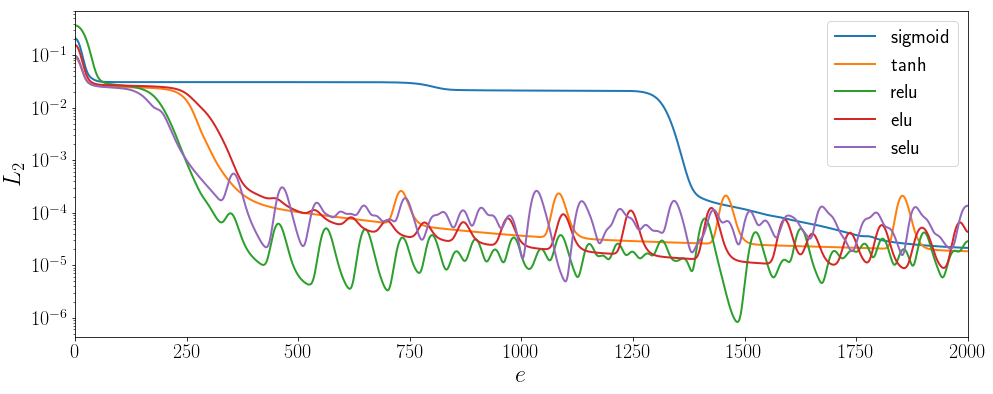

In [9]:
rc('text', usetex=True)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

colors = ["C{:1d}".format(i) for i in range(5)]

for i, key in enumerate(all_losses.keys()):
    smoothed = gaussian_filter1d(all_losses[key], sigma=10)
    ax.plot(range(1, epochs+1), smoothed, ls="-", lw=2, color=colors[i], label=key)
    
ax.set_xlabel("$e$", fontsize=hm.fontsize_label)
ax.set_xlim(1, epochs+1)
ax.set_ylabel("$L_2$", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)
savefig("bhaga_03_loss_activations")

Created model with 8321 weights.
Created model with 8321 weights.
Created model with 8321 weights.
Created model with 8321 weights.
Created model with 8321 weights.

activation / L_2 / L_1/ L_max / L_max_rel
sigmoid   : 2.1282e-05, 0.002785, 0.037736, 0.436310
tanh      : 1.8429e-05, 0.003380, 0.009754, 0.029195
relu      : 4.5789e-07, 0.000531, 0.003459, 0.039990
elu       : 6.9551e-06, 0.001927, 0.019101, 0.220848
selu      : 4.8835e-07, 0.000523, 0.003634, 0.035532

Maximum PLIC offset abs/rel: 9.7036e-05/5.6444e-04
Average PLIC offset abs/rel: 2.0471e-06/4.5652e-06


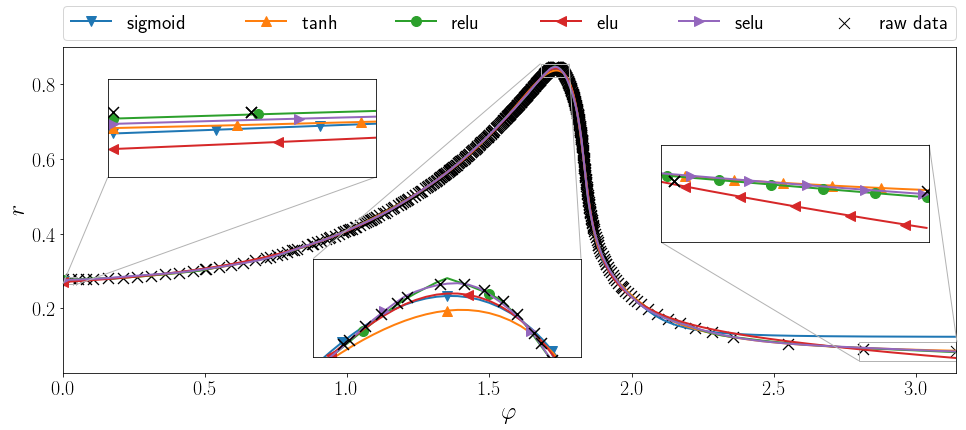

In [10]:
# statistics and plot
rad, phi = all_facets["bhaga_03_l16"].get_facets(polar=True)

fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))
# zoom windows
zoom_1 = plt.axes([0, 0, 1, 1], xticks=[], yticks=[], xlim=[-0.001, 0.05], ylim=[0.265, 0.285])
zoom_2 = plt.axes([0, 0, 1, 1], xticks=[], yticks=[], xlim=[1.68, 1.78], ylim=[0.82, 0.855])
zoom_3 = plt.axes([0, 0, 1, 1], xticks=[], yticks=[], xlim=[2.8, 3.145], ylim=[0.06, 0.11])

results = ""
lines = []
marker = ["v", "^", "o", "<", ">"]
markevery = [10, 11, 12, 13, 14]
for i, key in enumerate(all_models.keys()):
    model_dict["activation"] = activations[i]
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path + "/bhaga_03_l16_" + key + ".pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    phi_eval = torch.from_numpy(phi.astype(np.float64)).unsqueeze_(-1)
    rad_eval = model.forward(phi_eval).detach().squeeze().numpy()
    L2_min = np.min(all_losses[key])
    diff = np.absolute(rad - rad_eval)
    L_1 = np.mean(diff)
    L_max = np.max(diff)
    L_max_rel = np.max(diff/rad)
    results += "{:10s}: {:1.4e}, {:1.6f}, {:1.6f}, {:1.6f}\n".format(key, L2_min, L_1, L_max, L_max_rel)
    
    # plot
    phi_eval = torch.from_numpy(np.linspace(0, np.pi, 800).astype(np.float64)).unsqueeze_(-1)
    rad_eval = model.forward(phi_eval).detach().squeeze().numpy()
    lines.append(ax.plot(phi_eval.squeeze(), rad_eval, color=colors[i], lw=2, marker=marker[i], ms=10, markevery=1000, label=key)[0])
    zoom_1.plot(phi_eval.squeeze(), rad_eval, color=colors[i], lw=2, marker=marker[i], ms=10, markevery=markevery[i]-5)
    zoom_2.plot(phi_eval.squeeze(), rad_eval, color=colors[i], lw=2, marker=marker[i], ms=10, markevery=markevery[i])
    zoom_3.plot(phi_eval.squeeze(), rad_eval, color=colors[i], lw=2, marker=marker[i], ms=10, markevery=markevery[i]+5)

# print some statistics
print("\nactivation / L_2 / L_1/ L_max / L_max_rel")
print(results)
# sort points by polar angle to compute offset between intersection points
# (offset between two PLIC elements cutting the same edge)
phi_order = np.argsort(phi)
phi_sorted = phi[phi_order]
rad_sorted = rad[phi_order]
plic_offset = np.absolute(rad_sorted - np.roll(rad_sorted, -1))[1:-2:2]
plic_offset_rel = np.absolute((rad_sorted - np.roll(rad_sorted, -1)) / rad_sorted)[1:-2:2]
print("Maximum PLIC offset abs/rel: {:4.4e}/{:4.4e}".format(np.max(plic_offset), np.max(plic_offset_rel)))
print("Average PLIC offset abs/rel: {:4.4e}/{:4.4e}".format(np.mean(plic_offset), np.mean(plic_offset_rel)))

# raw data and zoom
lines.append(ax.scatter(phi, rad, marker="x", color="k", s=120, lw=1.0, label="raw data"))
ip_1 = InsetPosition(ax, [0.05, 0.6, 0.3, 0.3])
ip_2 = InsetPosition(ax, [0.28, 0.05, 0.3, 0.3])
ip_3 = InsetPosition(ax, [0.67, 0.4, 0.3, 0.3])
zoom_1.set_axes_locator(ip_1)
zoom_2.set_axes_locator(ip_2)
zoom_3.set_axes_locator(ip_3)
mark_inset(ax, zoom_1, loc1=3, loc2=4, fc="none", ec='0.7')
mark_inset(ax, zoom_2, loc1=2, loc2=1, fc="none", ec='0.7')
mark_inset(ax, zoom_3, loc1=3, loc2=1, fc="none", ec='0.7')
zoom_1.scatter(phi, rad, marker="x", color="k", s=120, lw=1.5, zorder=6)
zoom_2.scatter(phi[::10], rad[::10], marker="x", color="k", s=120, lw=1.5, zorder=6)
zoom_3.scatter(phi, rad, marker="x", color="k", s=120, lw=1.5, zorder=6)

ax.set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
ax.set_xlim(0, np.pi)
ax.set_ylabel(r"$r$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(handles=lines, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=6, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)

savefig("bhaga_03_radius_activations")

### Test various network architectures on case bhaga_03_l16

In [11]:
model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : None,
    "n_neurons" : None,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}
layers = range(1, 9)
nodes = range(20, 61, 10)

In [13]:
all_losses = {}
all_models = {}

epochs = 2000
rad, phi = all_facets["bhaga_03_l16"].get_facets(polar=True)
for n_layers in layers:
    for n_nodes in nodes:
        print("Testing MLP with \033[1m{} layer(s)\033[0m and \033[1m{} nodes\033[0m".format(n_layers, n_nodes))
        model_dict["n_layers"] = n_layers
        model_dict["n_neurons"] = n_nodes
        model = hm.SimpleMLP(**model_dict)
        model_path = output_path + "/bhaga_03_l16_selu_{:1d}_layers_{:2d}_nodes.pt".format(n_layers, n_nodes)
        model, losses = training_loop(model, model_path, phi, rad, epochs, 0.001)
        all_losses[model_path] = losses
        all_models[model_path] = copy.deepcopy(model)

Testing MLP with 1 layer(s) and 20 nodes
Created model with 61 weights.
Testing MLP with 1 layer(s) and 30 nodes
Created model with 91 weights.
Testing MLP with 1 layer(s) and 40 nodes
Created model with 121 weights.
Testing MLP with 1 layer(s) and 50 nodes
Created model with 151 weights.
Testing MLP with 1 layer(s) and 60 nodes
Created model with 181 weights.
Testing MLP with 2 layer(s) and 20 nodes
Created model with 481 weights.
Testing MLP with 2 layer(s) and 30 nodes
Created model with 1021 weights.
Testing MLP with 2 layer(s) and 40 nodes
Created model with 1761 weights.
Testing MLP with 2 layer(s) and 50 nodes
Created model with 2701 weights.
Testing MLP with 2 layer(s) and 60 nodes
Created model with 3841 weights.
Testing MLP with 3 layer(s) and 20 nodes
Created model with 901 weights.
Testing MLP with 3 layer(s) and 30 nodes
Created model with 1951 weights.
Testing MLP with 3 layer(s) and 40 nodes
Created model with 3401 weights.
Testing MLP with 3 layer(s) and 50 nodes
Create

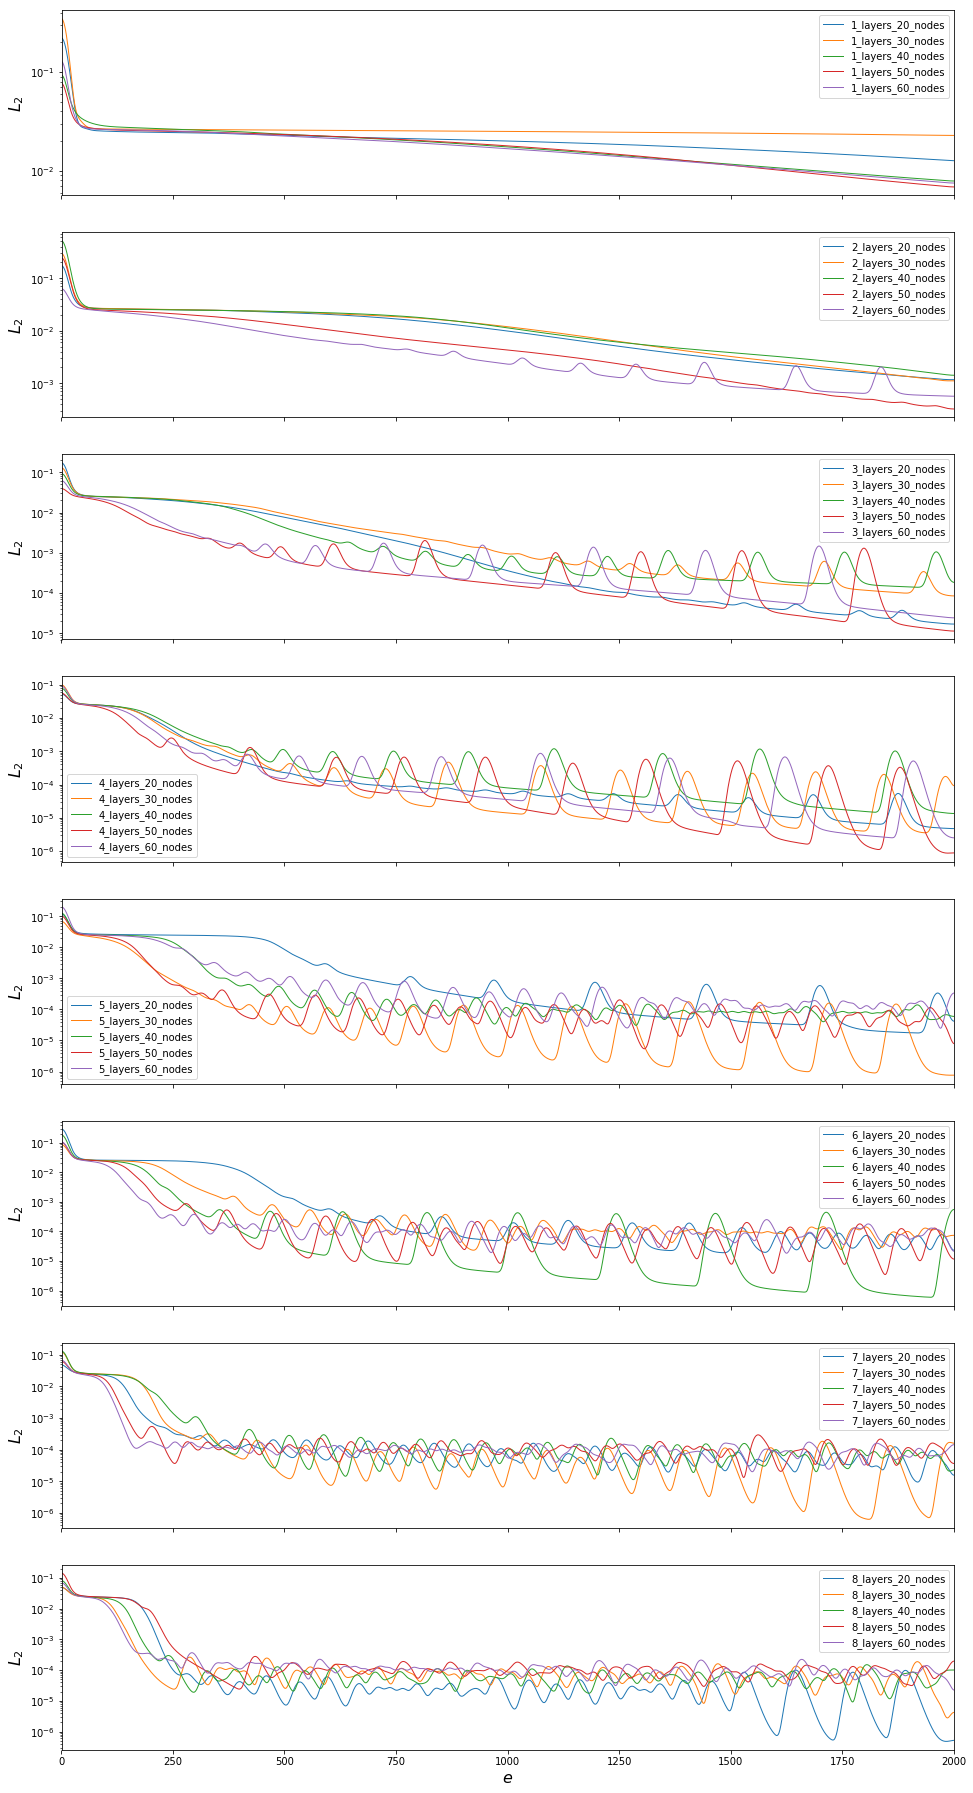

In [14]:
rc('text', usetex=False)
fig, axarr = plt.subplots(len(layers), 1, figsize=(hm.figure_width, 32), sharex=True)

phi_eval = torch.from_numpy(phi.astype(np.float64)).unsqueeze_(-1)
all_metrics = {}

for l in layers:
    for key in all_losses.keys():
        if "{:1d}_layers_".format(l) in key:
            smoothed = gaussian_filter1d(all_losses[key], sigma=10)
            axarr[l-1].plot(range(1, epochs+1), smoothed, lw=1, label=key.split("_selu_")[-1][:-3])
            # some metrics
            rad_eval = all_models[key].forward(phi_eval).detach().squeeze().numpy()
            diff = np.absolute(rad - rad_eval)
            all_metrics[key] = [np.min(all_losses[key]), np.mean(diff), np.max(diff), np.max(diff/rad)]
    axarr[l-1].set_ylabel("$L_2$", fontsize=16)
    axarr[l-1].set_yscale('log')
    axarr[l-1].set_xlim(1, epochs+1)
    
axarr[-1].set_xlabel("$e$", fontsize=16)
axarr[-1].set_xlim(1, epochs+1)
for ax in axarr: ax.legend()

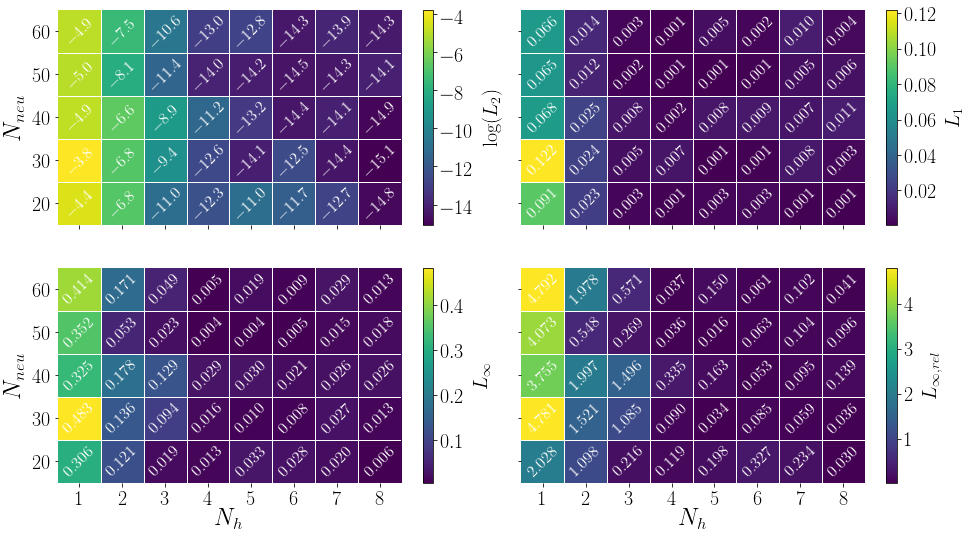

In [81]:
rc('text', usetex=True)
fig, axarr = plt.subplots(2, 2, figsize=(hm.figure_width, 8.7), sharex=True, sharey=True)
xtick_labels = [r"${:1d}$".format(l) for l in layers]
ytick_labels = [r"${:2d}$".format(n) for n in nodes[::-1]]
metric_labels = [r"$\mathrm{log}(L_2)$", r"$L_1$", r"$L_{\infty}$", r"$L_{\infty ,rel}$"]
count = 0
for row in range(2):
    for col in range(2):
        if count is 0:
            metric = np.log(np.asarray(list(all_metrics.values()))[:,count]).reshape(8, 5)[:,::-1].T
        else:
            metric = np.asarray(list(all_metrics.values()))[:,count].reshape(8, 5)[:,::-1].T
        im = axarr[row, col].imshow(metric)
        cbar = axarr[row, col].figure.colorbar(im, ax=axarr[row, col])
        cbar.ax.set_ylabel(metric_labels[count], rotation=90, va="bottom", fontsize=hm.fontsize_tick, labelpad=30)
        cbar.ax.tick_params(labelsize=hm.fontsize_tick)
        axarr[row, col].set_xticks(range(8))
        axarr[row, col].set_xticks(np.arange(0.5, 7.4, 1.0), minor=True)
        axarr[row, col].set_yticks(range(5))
        axarr[row, col].set_yticks(np.arange(0.5, 4.4, 1.0), minor=True)
        axarr[row, col].set_xticklabels(xtick_labels)
        axarr[row, col].set_yticklabels(ytick_labels)
        axarr[row, col].tick_params(labelsize=hm.fontsize_tick)
        for edge, spine in axarr[row, col].spines.items():
            spine.set_visible(False)
        axarr[row, col].grid(which="minor", color="w", linestyle='-', linewidth=1)
        axarr[row, col].tick_params(which="minor", bottom=False, left=False)
        count += 1
        # errors as text
        if count is 1:
            form = r"${:2.1f}$"
        else:
            form = r"${:1.3f}$"
        for i in range(5):
            for j in range(8):
                text = axarr[row, col].text(j, i, form.format(metric[i, j]),
                ha="center", va="center", color="w", fontsize=16, rotation=45)
                
            

axarr[0,0].set_ylabel(r"$N_{neu}$", fontsize=hm.fontsize_label)
axarr[1,0].set_ylabel(r"$N_{neu}$", fontsize=hm.fontsize_label)
axarr[1,0].set_xlabel(r"$N_{h}$", fontsize=hm.fontsize_label)
axarr[1,1].set_xlabel(r"$N_{h}$", fontsize=hm.fontsize_label)

plt.subplots_adjust(wspace=0.08)
savefig("bhaga_03_l16_selu_architecture_metrics")

Created model with 12901 weights.
[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.] [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.  10.  10.  10.]
Created model with 12901 weights.
[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.] [ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.]
Created model with 12901 weights.
[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.] [ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.]
Created model with 12901 weights.
[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.] [ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.]


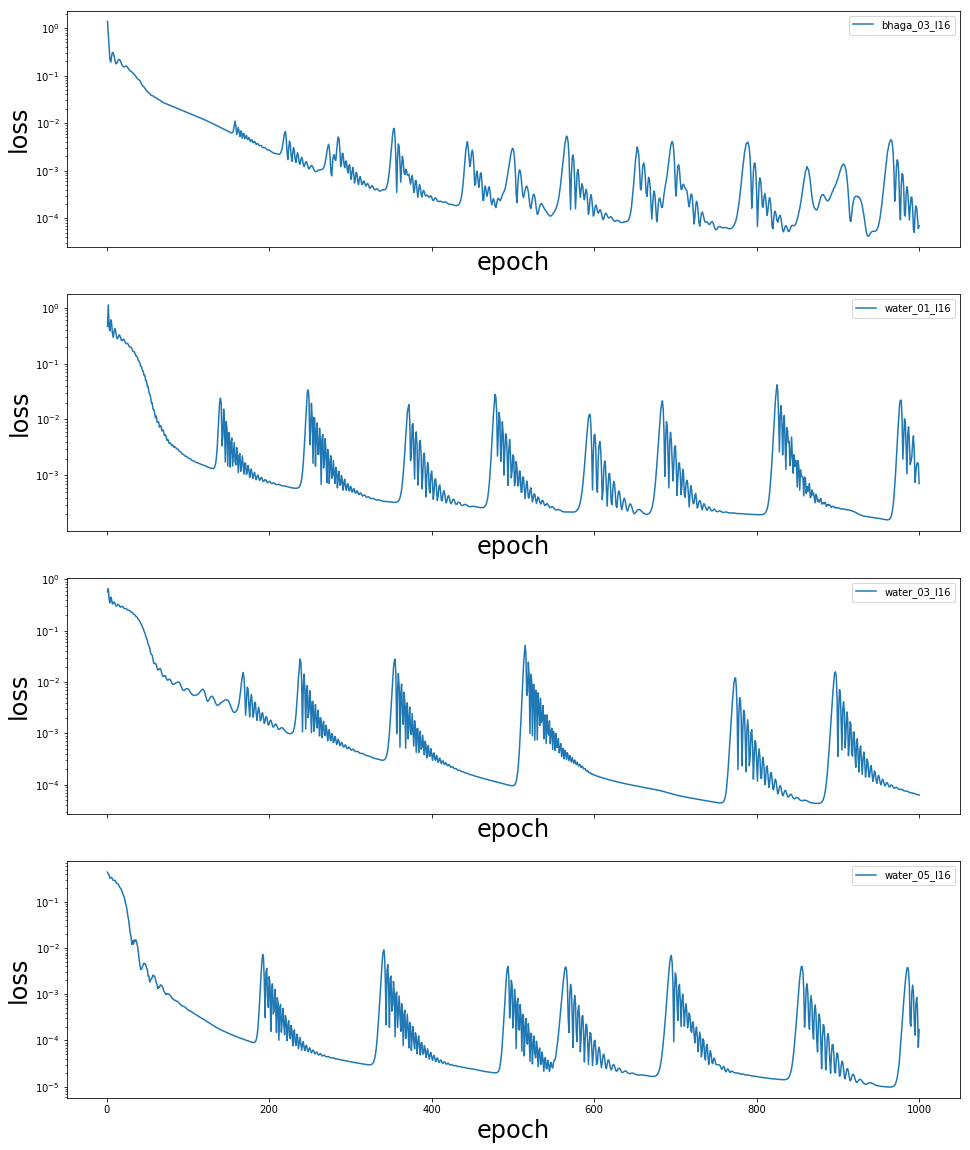

In [98]:
rc('text', usetex=False)
fig, axarr = plt.subplots(len(names), 1, figsize=(hm.figure_width, len(names)*5), sharex=True)

model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 6,
    "n_neurons" : 50,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}

epochs = 1000
for i, name in enumerate(names):
    model = hm.SimpleMLP(**model_dict)
    rad, phi = all_facets[name].get_facets(polar=True)
    rad_norm = (rad - np.min(rad)) / (np.max(rad) - np.min(rad))
    model_path = output_path + "/" + name + "_selu_best.pt"
    model, losses = training_loop(model, model_path, phi, rad_norm, epochs, 0.001)
    axarr[i].plot(range(1, epochs+1), losses, label=name)
    axarr[i].set_xlabel("epoch", fontsize=hm.fontsize_label)
    axarr[i].set_ylabel("loss", fontsize=hm.fontsize_label)
    axarr[i].set_yscale('log')
    axarr[i].legend()

Created model with 12901 weights.
Created model with 12901 weights.
Created model with 12901 weights.
Created model with 12901 weights.


Text(0.5,0,'$\\varphi$')

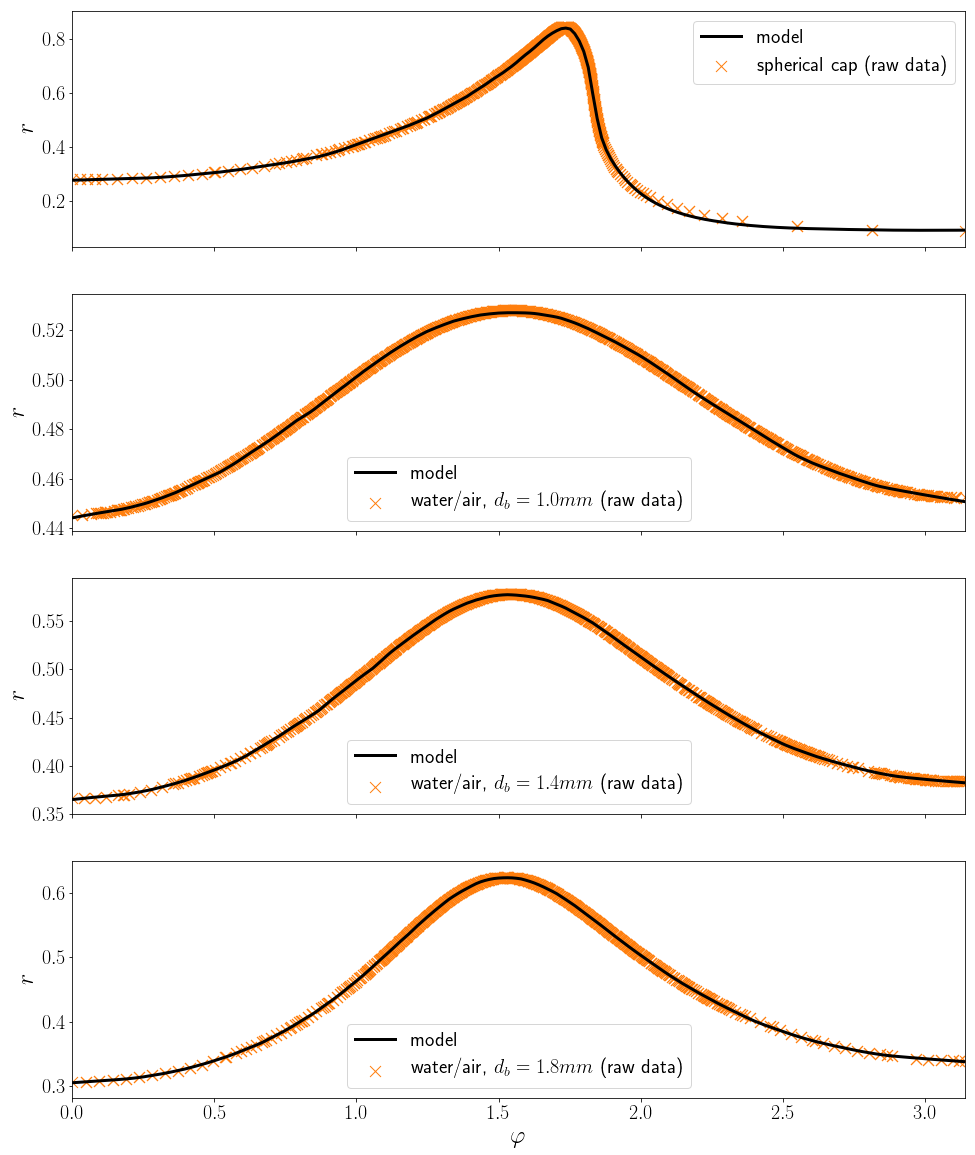

In [99]:
rc('text', usetex=True)

fig, axarr = plt.subplots(4, 1, figsize=(hm.figure_width, 20), sharex=True)
labels = ["spherical cap", "water/air, $d_b=1.0mm$", "water/air, $d_b=1.4mm$", "water/air, $d_b=1.8mm$"]

for i, name in enumerate(names):
    model = hm.SimpleMLP(**model_dict)
    rad, phi = all_facets[name].get_facets(polar=True)
    model_path = output_path + "/" + name + "_selu_best.pt"
    model.load_state_dict(torch.load(model_path))
    model.eval()
    phi_eval = torch.from_numpy(np.linspace(0.0, np.pi, 200)).unsqueeze_(-1)
    rad_eval = model.forward(phi_eval).detach().squeeze().numpy()
    rad_eval = rad_eval * (np.max(rad) - np.min(rad)) + np.min(rad)
    
    axarr[i].plot(phi_eval.squeeze(), rad_eval, color="k", lw=hm.line_width, label="model")
    axarr[i].scatter(phi, rad, marker="x", s=120, lw=1, color="C1", label="{} (raw data)".format(labels[i]))
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].set_ylabel(r"$r$", fontsize=hm.fontsize_label)
    axarr[i].set_xlim(0.0, np.pi)
    axarr[i].legend(fontsize=hm.fontsize_legend)
    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)

## Approximate shapes

In [59]:
dir(torch.nn.functional)

['GRID_SAMPLE_INTERPOLATION_MODES',
 'GRID_SAMPLE_PADDING_MODES',
 'List',
 '_Reduction',
 '_VF',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_adaptive_max_pool1d',
 '_adaptive_max_pool2d',
 '_adaptive_max_pool3d',
 '_add_docstr',
 '_fractional_max_pool2d',
 '_fractional_max_pool3d',
 '_get_softmax_dim',
 '_infer_size',
 '_list_with_default',
 '_max_pool1d',
 '_max_pool2d',
 '_max_pool3d',
 '_no_grad_embedding_renorm_',
 '_pad_circular',
 '_pair',
 '_pointwise_loss',
 '_single',
 '_smooth_l1_loss',
 '_triple',
 '_unpool_output_size',
 'adaptive_avg_pool1d',
 'adaptive_avg_pool2d',
 'adaptive_avg_pool3d',
 'adaptive_max_pool1d',
 'adaptive_max_pool1d_with_indices',
 'adaptive_max_pool2d',
 'adaptive_max_pool2d_with_indices',
 'adaptive_max_pool3d',
 'adaptive_max_pool3d_with_indices',
 'affine_grid',
 'alpha_dropout',
 'assert_int_or_pair',
 'avg_pool1d',
 'avg_pool2d',
 'avg_pool3d',
 'batch_norm',
 'bilinear',
 'b

In [29]:
for i, case in enumerate(shapes.keys()):
    px, py = shapes[case]
    radius, phi = polar_coordinates(py, px)
    model = SimpleMLP(n_layers=6, n_neurons=40, activation=torch.sigmoid)
    path = "./models/" + case + ".pt"
    model = approximate_function(phi, radius, model, l_rate=0.01, max_iter=4000, path=path)

Loss/max. dev. decreased in epoch 1: 0.12757495690053489/0.5296252288536747
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2: 0.04128358623108479/0.6443161156485384
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 5: 0.032461013669395085/0.5834241670047746
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 11: 0.031349036759034554/0.5669572536280925
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 17: 0.03103485650646031/0.5230532815999952
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 23: 0.030697711342245/0.5421177614812118
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 53: 0.030697414399170266/0.5420268463439815
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 64: 0.030697254404013965/0.5419758243519179
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 80: 0.03069694838141994

Loss/max. dev. decreased in epoch 172: 0.03060375219839837/0.5422471171718816
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 173: 0.030591258798993874/0.5423170026581234
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 174: 0.030576804289378284/0.5423814947507762
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 175: 0.03056005936833591/0.5424541614941325
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 176: 0.03054063559544354/0.542548853449296
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 177: 0.0305180759436616/0.5426731875617156
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 178: 0.03049184447691166/0.5428262272089511
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 179: 0.030461311590260488/0.5430012874755792
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 180: 0.030425

Loss/max. dev. decreased in epoch 270: 0.00033463565848584995/0.07598005248859585
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 277: 0.0002307783446752108/0.1120386363766977
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 288: 0.00022001119237912963/0.13538129751930852
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 295: 0.00021563660829389958/0.1280043952035253
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 297: 0.00018795468834692587/0.12570463706721896
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 299: 0.00018746457201424988/0.12315729530525482
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 304: 0.00018115200837236843/0.11668548875613899
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 311: 0.00017714960286716448/0.11386416821809311
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decr

Loss/max. dev. decreased in epoch 415: 0.00014410152783668424/0.11108225112354841
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 416: 0.00014382578986715311/0.1109317436036596
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 417: 0.00014354931760447964/0.11078865558523115
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 418: 0.00014327152781449604/0.11062659040156453
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 419: 0.0001429927905046719/0.11047218335678782
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 420: 0.00014271342861901944/0.11031960087909484
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 421: 0.00014243284543473392/0.11015404550526581
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 422: 0.00014215125632649017/0.10999946586545062
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. dec

Loss/max. dev. decreased in epoch 484: 0.00012340873515533877/0.09853100908616641
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 485: 0.00012310647261790526/0.09833137694977484
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 486: 0.0001228053346553623/0.0981318980961241
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 487: 0.00012250539088658554/0.09793225506173692
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 488: 0.00012220670968966056/0.09773346402407701
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 489: 0.00012190936078601681/0.09753448791970104
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 490: 0.00012161341248033277/0.09733591732703034
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 491: 0.00012131893267070691/0.09713796676251818
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. dec

Loss/max. dev. decreased in epoch 577: 0.00010356957680072778/0.08325165989098843
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 578: 0.00010342210850181224/0.08312108394588807
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 579: 0.00010327489301814763/0.08299086422718899
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 580: 0.00010312789846920662/0.08286095331797855
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 581: 0.00010298109332111171/0.08273137731819766
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 582: 0.00010283444636791412/0.08260208425862015
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 583: 0.00010268792669509403/0.0824731053721185
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 584: 0.00010254150366437574/0.08234437956919433
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. de

Loss/max. dev. decreased in epoch 728: 7.650150848935212e-05/0.06602674410077772
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 729: 7.611952542523985e-05/0.06598341719551057
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 730: 7.579280404642099e-05/0.0657165491359506
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 731: 7.553456455375047e-05/0.06535396686582906
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 732: 7.523859054163751e-05/0.06530771729917273
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 733: 7.488251646097299e-05/0.06490767982023082
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 734: 7.454938425087738e-05/0.06471424821186211
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 735: 7.42667983412752e-05/0.0645355247788929
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in

Loss/max. dev. decreased in epoch 798: 5.689273096532258e-05/0.04944945720467431
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 799: 5.669090296111917e-05/0.0492491456921646
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 800: 5.649175811990323e-05/0.04905894221556012
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 801: 5.629524894398803e-05/0.048857769768848924
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 802: 5.610134265548372e-05/0.04867108389241398
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 803: 5.591005276669995e-05/0.04847652788047735
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 804: 5.5721371720432976e-05/0.048288367913587815
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 805: 5.553527264613566e-05/0.04810265910983569
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreas

Loss/max. dev. decreased in epoch 865: 4.766708231099105e-05/0.039255760039998144
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 866: 4.756991146836226e-05/0.03913595698822786
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 867: 4.74733450425119e-05/0.03901717977914443
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 868: 4.737736820263116e-05/0.03889865418169017
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 869: 4.72819665793475e-05/0.03878093897736595
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 870: 4.7187126339690467e-05/0.038663643079487
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 871: 4.709283411768533e-05/0.03854694660504637
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 872: 4.699907703104217e-05/0.03843081162676233
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased i

Loss/max. dev. decreased in epoch 1045: 3.562169936321899e-05/0.029407615533720635
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1046: 3.557016327238807e-05/0.029226945794732034
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1047: 3.551361404113525e-05/0.029223608314067215
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1048: 3.545433249235319e-05/0.029064922186552905
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1049: 3.5397110930789125e-05/0.029009547710883557
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1050: 3.534388428882253e-05/0.028917557534983332
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1051: 3.529350746588921e-05/0.028782321042491385
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1052: 3.524269808863978e-05/0.028749288071195422
Saving model as ./models/bhaga_03_l16.pt
Loss/ma

Loss/max. dev. decreased in epoch 1115: 3.22523876408328e-05/0.02391553791818167
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1116: 3.22099094791898e-05/0.023847465849072297
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1117: 3.2167564072447536e-05/0.02378557773215889
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1118: 3.212535081303948e-05/0.02371922167549101
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1119: 3.2083269281757595e-05/0.023656837746706502
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1120: 3.204131864198003e-05/0.02359251502638604
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1121: 3.199949803863081e-05/0.023529501998341376
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1122: 3.1957806568484425e-05/0.023466758655937975
Saving model as ./models/bhaga_03_l16.pt
Loss/max. d

Loss/max. dev. decreased in epoch 1300: 2.6337434527362892e-05/0.02077825677752146
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1301: 2.6315080641912145e-05/0.02063790794372314
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1302: 2.629112344272318e-05/0.020668891179821652
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1303: 2.6264956973014332e-05/0.02051750044481232
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1304: 2.623691028651526e-05/0.02054888276512344
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1305: 2.6208092725178068e-05/0.0204177199166288
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1306: 2.617967366315206e-05/0.020419046165509602
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1307: 2.6152492590520527e-05/0.02034097315724999
Saving model as ./models/bhaga_03_l16.pt
Loss/max. 

Loss/max. dev. decreased in epoch 1477: 2.320305464842962e-05/0.01968167140000192
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1478: 2.3119697947489564e-05/0.019847610131039625
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1479: 2.3069909578150282e-05/0.019664492127807798
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1480: 2.3056951520826226e-05/0.019591121969919967
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1486: 2.3023427337428965e-05/0.01925097192134817
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1487: 2.297870793632764e-05/0.0194438594302853
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1488: 2.2938481214398183e-05/0.019249208709250842
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1489: 2.2908328168898263e-05/0.019305289783440566
Saving model as ./models/bhaga_03_l16.pt
Loss/m

Loss/max. dev. decreased in epoch 1655: 2.1253958569500307e-05/0.020004771424625256
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1656: 2.1194080722075895e-05/0.020065539331496546
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1663: 2.1170079023722908e-05/0.01978844392331676
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1664: 2.1119768575661738e-05/0.01957439043215954
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1665: 2.1091581550204625e-05/0.019623760699778767
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1666: 2.1086166755963636e-05/0.01961521705136883
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1671: 2.1082016377221623e-05/0.01924244867125173
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1672: 2.105497136856975e-05/0.019395444073907198
Saving model as ./models/bhaga_03_l16.pt
Loss/

Loss/max. dev. decreased in epoch 1850: 1.9917674237717736e-05/0.019390205671600727
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1851: 1.991071236429136e-05/0.01935623728179975
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1859: 1.9902735773996932e-05/0.01887622552663064
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1860: 1.9883484089323107e-05/0.019026684157186294
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1861: 1.986505826373783e-05/0.018812465141617718
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1862: 1.984896073153037e-05/0.018895065550031648
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1863: 1.983588464939713e-05/0.018761682987032763
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1864: 1.9825944707413244e-05/0.01877052483464206
Saving model as ./models/bhaga_03_l16.pt
Loss/ma

Loss/max. dev. decreased in epoch 2165: 1.8831547702996126e-05/0.019743611900098462
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2166: 1.880817288189442e-05/0.019803606851806946
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2167: 1.8801782908256124e-05/0.01974745432400507
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2178: 1.8785976529987597e-05/0.019077214478635876
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2179: 1.8771084132393977e-05/0.019212618853771193
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2180: 1.8758345730892017e-05/0.019045824646007486
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2181: 1.8748011173333618e-05/0.01911610132926765
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2182: 1.8740014131701523e-05/0.01901967410130251
Saving model as ./models/bhaga_03_l16.pt
Loss

Loss/max. dev. decreased in epoch 2612: 1.7879348048989914e-05/0.020948522732713803
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2621: 1.7846070520237268e-05/0.02020950798393044
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2622: 1.7805242856238378e-05/0.020166016379572244
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2632: 1.7755148857799614e-05/0.019504856804279075
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2633: 1.774417107937289e-05/0.019498212274176044
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2643: 1.773782297026287e-05/0.0189017541539917
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2644: 1.7708871602990913e-05/0.01903531742280966
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2645: 1.769072933240275e-05/0.018885294384003312
Saving model as ./models/bhaga_03_l16.pt
Loss/ma

Loss/max. dev. decreased in epoch 2870: 1.711339179514504e-05/0.017710697415236162
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2871: 1.7109073945850502e-05/0.017666265629919534
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2872: 1.710470139275355e-05/0.01768556021155314
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2873: 1.7100285110789387e-05/0.017640644441431888
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2874: 1.7095838314536046e-05/0.017658617600263812
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2875: 1.7091375891010097e-05/0.017617354194037343
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2876: 1.7086911263890364e-05/0.017630263482294503
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 2877: 1.7082456875798363e-05/0.017593822651388563
Saving model as ./models/bhaga_03_l16.pt
Los

Loss/max. dev. decreased in epoch 3078: 1.6574152563922132e-05/0.01660883425234902
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3079: 1.6569563403050694e-05/0.01665439305392888
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3080: 1.656502239316271e-05/0.016578957805724742
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3081: 1.6560537831658838e-05/0.01661965700781233
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3082: 1.655611074392864e-05/0.016548718106960944
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3083: 1.6551744307718386e-05/0.016586170589472773
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3084: 1.6547435994465936e-05/0.016517515805608618
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3085: 1.654319006572977e-05/0.016553577440090728
Saving model as ./models/bhaga_03_l16.pt
Loss/m

Loss/max. dev. decreased in epoch 3604: 1.558337683991165e-05/0.015829056992748988
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3605: 1.5530378157276457e-05/0.015647331537713402
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3626: 1.5491798859236196e-05/0.01432654685287954
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3627: 1.542559960684125e-05/0.014721369765816283
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3628: 1.5380912878928708e-05/0.014406933523221407
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3629: 1.535210430604591e-05/0.014647837855873397
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3630: 1.5332248034831164e-05/0.014490631906755883
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 3631: 1.5317807950651216e-05/0.014597736030338218
Saving model as ./models/bhaga_03_l16.pt
Loss

Loss/max. dev. decreased in epoch 229: 0.0006702625289250287/0.046591256121841895
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 230: 0.0006702624865415355/0.04659213698395964
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 231: 0.0006702624454332695/0.046593554787640934
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 232: 0.000670262407640788/0.046594769162272065
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 233: 0.0006702623692777901/0.046595207330648425
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 234: 0.0006702623278615174/0.0465947265665273
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 235: 0.0006702622860553718/0.04659364432615393
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 236: 0.0006702622464223591/0.046592541558226785
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decrea

Loss/max. dev. decreased in epoch 308: 0.0006702588593560572/0.04659266630708753
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 309: 0.0006702588046567772/0.046592631246666794
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 310: 0.0006702587497196311/0.046592594043142144
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 311: 0.0006702586945424477/0.046592569380768833
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 312: 0.0006702586391225455/0.04659256334798634
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 313: 0.000670258583459217/0.04659257074937179
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 314: 0.0006702585275520851/0.0465925791405456
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 315: 0.0006702584713991228/0.046592576662355834
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreas

Loss/max. dev. decreased in epoch 378: 0.0006702543658422983/0.04659168357826915
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 379: 0.0006702542903419585/0.046591667154572025
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 380: 0.0006702542144712618/0.04659165109637292
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 381: 0.0006702541382276881/0.046591635544698695
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 382: 0.0006702540616086982/0.04659162025592495
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 383: 0.0006702539846117249/0.046591604795171104
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 384: 0.0006702539072341858/0.04659158883547754
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 385: 0.0006702538294734713/0.04659157235925976
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decrea

Loss/max. dev. decreased in epoch 451: 0.0006702476956834658/0.04659032595136703
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 452: 0.0006702475848135557/0.04659030383177426
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 453: 0.0006702474733112844/0.04659028161397982
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 454: 0.0006702473611716079/0.046590259290428426
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 455: 0.00067024724838943/0.046590236848308875
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 456: 0.0006702471349596064/0.04659021427863952
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 457: 0.0006702470208769354/0.046590191581737994
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 458: 0.0006702469061361637/0.046590168765466566
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreas

Loss/max. dev. decreased in epoch 533: 0.0006702359445207754/0.046588041934350566
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 534: 0.0006702357589462853/0.04658800666894153
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 535: 0.0006702355720712374/0.04658797117776037
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 536: 0.000670235383882829/0.04658793545850909
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 537: 0.0006702351943680794/0.04658789950884018
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 538: 0.0006702350035138627/0.04658786332650655
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 539: 0.0006702348113068608/0.046587826909395114
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 540: 0.0006702346177336071/0.046587790255428696
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreas

Loss/max. dev. decreased in epoch 615: 0.0006702148975848022/0.046584150888449194
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 616: 0.000670214542171409/0.0465840867400476
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 617: 0.0006702141835194928/0.04658402205147605
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 618: 0.0006702138215876275/0.046583956816177385
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 619: 0.0006702134563336994/0.04658389102748928
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 620: 0.000670213087714907/0.04658382467864386
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 621: 0.0006702127156877408/0.04658375776276724
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 622: 0.0006702123402079791/0.04658369027288045
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased 

Loss/max. dev. decreased in epoch 697: 0.0006701696298624886/0.046576265117213134
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 698: 0.0006701687754966268/0.04657612083803475
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 699: 0.0006701679101879873/0.04657597485524023
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 700: 0.000670167033744118/0.046575827140717396
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 701: 0.0006701661459683391/0.046575677665771364
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 702: 0.0006701652466596469/0.04657552640110918
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 703: 0.0006701643356125935/0.04657537331682571
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 704: 0.0006701634126171773/0.04657521838238787
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreas

Loss/max. dev. decreased in epoch 788: 0.000670003679858118/0.046550060951355776
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 789: 0.0006699999501943923/0.04654950175115763
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 790: 0.0006699961419165369/0.04654893175709085
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 791: 0.0006699922528323547/0.04654835068897639
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 792: 0.0006699882806737222/0.04654775825756696
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 793: 0.0006699842230934621/0.04654715416419769
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 794: 0.0006699800776620253/0.04654653810042042
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 795: 0.0006699758418640531/0.04654590974762235
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased

Loss/max. dev. decreased in epoch 871: 0.0006688674961175153/0.04640179764839181
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 872: 0.0006688253205217636/0.0463967860640106
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 873: 0.000668781388969805/0.04639159082710498
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 874: 0.0006687356161276263/0.04638620423629963
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 875: 0.0006686879124589156/0.04638061827579931
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 876: 0.0006686381840112787/0.046374824598169884
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 877: 0.0006685863321781799/0.046368814503932154
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 878: 0.0006685322534313204/0.04636257891736595
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased

Loss/max. dev. decreased in epoch 951: 0.0006284381261549095/0.04275624485748686
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 952: 0.0006261461841641663/0.04254937940005893
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 953: 0.0006237155816040597/0.04232859368224551
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 954: 0.0006211375323086241/0.04209277373695569
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 955: 0.0006184028711126348/0.04184071431093428
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 956: 0.0006155021102524057/0.04157111325709406
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 957: 0.0006124255218995454/0.04128256630895477
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 958: 0.0006091632530586448/0.0411717214132955
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased 

Loss/max. dev. decreased in epoch 1038: 4.62588142160645e-05/0.011342555203781468
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1039: 4.115711109769409e-05/0.012715150949155873
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1040: 3.0114598504922004e-05/0.01142354028501813
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1041: 1.9250225414212402e-05/0.009119975228287003
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1044: 1.7826125296354843e-05/0.008525422682926553
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1045: 1.1966751322485353e-05/0.0065791993312378505
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1048: 1.0886100431550433e-05/0.011733094827167778
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1049: 1.0172126967125998e-05/0.012048102585087983
Saving model as ./models/water_01_l16.pt
Los

Loss/max. dev. decreased in epoch 1163: 1.0294098200658155e-07/0.0024315328886745924
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1164: 1.0250689144346023e-07/0.0024170519284165692
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1165: 1.0208291050854834e-07/0.0024338756701747233
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1166: 1.0167850438960331e-07/0.0024166059984388477
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1167: 1.013134226364818e-07/0.002441532185793016
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1168: 1.0100721849823654e-07/0.002417736830483741
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1169: 1.0078131211027366e-07/0.00245109327454357
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1170: 1.0066579262153051e-07/0.0024151399367330906
Saving model as ./models/water_01_l16.

Loss/max. dev. decreased in epoch 1343: 6.660686843223482e-08/0.002351766081020057
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1344: 6.64497223446181e-08/0.0023479579691702557
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1345: 6.629345069087055e-08/0.002350381984848049
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1346: 6.613809393997672e-08/0.002346045800522001
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1347: 6.598377221125389e-08/0.0023490557413227142
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1348: 6.583058641129331e-08/0.002344014179703313
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1349: 6.56787564431475e-08/0.002347845540187743
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1350: 6.55285177222873e-08/0.00234179694913933
Saving model as ./models/water_01_l16.pt
Loss/max. 

Loss/max. dev. decreased in epoch 1534: 5.18431670063541e-08/0.002189834128401069
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1535: 5.173117173173027e-08/0.00218766824538813
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1536: 5.161987028781047e-08/0.002188000398804457
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1537: 5.1509323953189656e-08/0.002186906414455514
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1538: 5.1399506990442876e-08/0.0021861554470709588
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1539: 5.129032876105836e-08/0.0021860421552833964
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1540: 5.118167073083506e-08/0.002184429042739189
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1541: 5.1073430753755616e-08/0.002184986392993249
Saving model as ./models/water_01_l16.pt
Loss/

Loss/max. dev. decreased in epoch 1764: 4.3734242032306866e-08/0.0020167636063528893
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1765: 4.363625788513025e-08/0.002018244675037084
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1766: 4.3539444066664656e-08/0.0020173321025760416
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1767: 4.344386802590933e-08/0.0020170903808049423
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1768: 4.334932607982506e-08/0.0020177683342302855
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1769: 4.3255483449052893e-08/0.002016161904106528
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1770: 4.316204517754293e-08/0.0020178030415305415
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 1771: 4.306884025228012e-08/0.0020156439259038095
Saving model as ./models/water_01_l16.pt

Loss/max. dev. decreased in epoch 2071: 3.7774008446137885e-08/0.001879787198204641
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 2072: 3.7690462648769934e-08/0.0018792952803382001
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 2073: 3.760754910147297e-08/0.0018799208463648465
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 2074: 3.752525640464831e-08/0.0018794249284187492
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 2075: 3.7443576870918547e-08/0.001880028208364859
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 2076: 3.736249946311007e-08/0.0018795190640575887
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 2077: 3.728201683567776e-08/0.0018801132147326927
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 2078: 3.720211842500138e-08/0.0018795734118989271
Saving model as ./models/water_01_l16.pt

Loss/max. dev. decreased in epoch 3451: 3.202542471817473e-08/0.0015895800693455087
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3452: 3.195913568987182e-08/0.001589570205825841
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3453: 3.189331450715004e-08/0.0015895576081942364
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3454: 3.182795582860009e-08/0.0015895420928382364
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3455: 3.176305438645972e-08/0.0015895238746790885
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3456: 3.169860498525596e-08/0.0015895028227285168
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3457: 3.1634602500836656e-08/0.001589479087691581
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3458: 3.157104187913691e-08/0.001589452607973607
Saving model as ./models/water_01_l16.pt
Lo

Loss/max. dev. decreased in epoch 3529: 2.7938347396836163e-08/0.0015820404439303992
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3530: 2.7896804378705432e-08/0.0015819183847333163
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3531: 2.785546815554055e-08/0.0015816956231348711
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3532: 2.7814336976079503e-08/0.0015816035910176107
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3533: 2.7773409168604646e-08/0.0015813344836111964
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3534: 2.773268344795758e-08/0.0015812990570598373
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3535: 2.769215888245973e-08/0.0015809475204391354
Saving model as ./models/water_01_l16.pt
Loss/max. dev. decreased in epoch 3536: 2.7651835641905826e-08/0.0015810181279312108
Saving model as ./models/water_01_l1

Loss/max. dev. decreased in epoch 198: 0.001923101078973119/0.08734206166653286
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 199: 0.0019230981878363492/0.08733497943455953
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 200: 0.0019230952391029441/0.08733139183512334
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 201: 0.0019230921388304417/0.08733169532267776
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 202: 0.0019230889006694042/0.08733549771311999
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 203: 0.0019230856165607824/0.08734176507107982
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 204: 0.0019230823777721838/0.08734908019166893
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 205: 0.0019230792104990768/0.08735595298371124
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased 

Loss/max. dev. decreased in epoch 287: 0.001922690541773286/0.08736638290635557
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 288: 0.0019226835397867575/0.08736648379969453
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 289: 0.0019226764587468163/0.08736656138241566
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 290: 0.0019226692974220513/0.08736663942406436
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 291: 0.0019226620545415838/0.08736673900556391
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 292: 0.0019226547288028755/0.08736687373633928
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 293: 0.0019226473188838913/0.08736704718812316
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 294: 0.00192263982344792/0.08736725296063386
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in

Loss/max. dev. decreased in epoch 381: 0.0019213907286221895/0.08736323666589607
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 382: 0.0019213640361107967/0.08736269586724466
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 383: 0.0019213368452961482/0.08736213080372945
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 384: 0.001921309143455861/0.08736154080187974
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 385: 0.0019212809174681202/0.08736092522784233
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 386: 0.0019212521537977166/0.08736028342423979
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 387: 0.0019212228384814327/0.08735961465080083
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 388: 0.0019211929571129574/0.08735891804482798
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased 

Loss/max. dev. decreased in epoch 464: 0.0019148086320178274/0.08705687034539145
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 465: 0.001914602674867917/0.08704520881479605
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 466: 0.0019143900078242742/0.08703313814903307
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 467: 0.001914170366873493/0.08702064445442304
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 468: 0.0019139434763756598/0.08700771336781238
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 469: 0.0019137090485225078/0.086994330038971
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 470: 0.0019134667827676796/0.08698047911155732
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 471: 0.0019132163652265577/0.08696614470213826
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in 

Loss/max. dev. decreased in epoch 547: 0.00178856104425802/0.08204248904445971
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 548: 0.001782330519340911/0.0818862086535031
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 549: 0.0017757449931559061/0.08172521198557225
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 550: 0.0017687814738750946/0.08155916194568946
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 551: 0.0017614157401473704/0.08138766683537346
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 552: 0.001753622360674428/0.08121026477588683
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 553: 0.0017453747152538534/0.08102640937413635
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 554: 0.001736644998518828/0.08083546078977227
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in ep

Loss/max. dev. decreased in epoch 632: 1.1482601630176817e-05/0.016379698542855814
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 633: 8.990608575391944e-06/0.015529649658249878
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 634: 8.22998473793898e-06/0.014585354874954382
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 638: 6.946747969374964e-06/0.012188904975111547
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 639: 5.80716467658044e-06/0.012238577923007643
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 640: 5.637844901849751e-06/0.01235406493487623
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 643: 5.250559009372019e-06/0.011852223631133085
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 644: 4.518659595213366e-06/0.011192190101319888
Saving model as ./models/water_02_l16.pt
Loss/max. dev. dec

Loss/max. dev. decreased in epoch 720: 8.633798145562042e-07/0.006914924475751483
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 721: 8.576664993829174e-07/0.006891516779019946
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 722: 8.520470108176179e-07/0.006869207238957897
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 723: 8.466723037740189e-07/0.0068478436557802835
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 724: 8.414833324891269e-07/0.006826565000159657
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 725: 8.363128429105723e-07/0.006801081015992971
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 726: 8.3109228876044e-07/0.006776025255317175
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 727: 8.259142395148552e-07/0.006748267378859585
Saving model as ./models/water_02_l16.pt
Loss/max. dev. de

Loss/max. dev. decreased in epoch 798: 5.550695868701931e-07/0.0056150643523475985
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 799: 5.520470335681266e-07/0.005602326116168399
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 800: 5.490456962529793e-07/0.005587272526868081
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 801: 5.460686134994759e-07/0.005575448524317239
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 802: 5.43121262180757e-07/0.005559454156276011
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 803: 5.402144783240382e-07/0.005549060066492362
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 804: 5.373689669108953e-07/0.005531083722464913
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 805: 5.34626524695517e-07/0.005523380000007794
Saving model as ./models/water_02_l16.pt
Loss/max. dev. de

Loss/max. dev. decreased in epoch 918: 3.0655338891640136e-07/0.004185322198201169
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 919: 3.0521065884398116e-07/0.004177632508404416
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 920: 3.0386484136287877e-07/0.004165155463756898
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 921: 3.02518836957409e-07/0.004157406218314508
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 922: 3.0118113135876544e-07/0.004145923126337214
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 923: 2.99859177264462e-07/0.004136811368859461
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 924: 2.985553840251359e-07/0.0041270755406681014
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 925: 2.972668364619023e-07/0.004116422706872569
Saving model as ./models/water_02_l16.pt
Loss/max. dev

Loss/max. dev. decreased in epoch 1039: 2.0085164578292577e-07/0.003213901508484718
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1044: 1.982712489986747e-07/0.0031919966659677
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1049: 1.95966550655518e-07/0.0031714058350911234
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1050: 1.9504998941880141e-07/0.003165133953703103
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1054: 1.938119693384488e-07/0.0031533823213927836
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1055: 1.921519966739017e-07/0.003140740756784277
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1059: 1.9153958190692024e-07/0.0031328592902516994
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1060: 1.8990445933207474e-07/0.0031154625890472687
Saving model as ./models/water_02_l16.pt
Los

Loss/max. dev. decreased in epoch 1126: 1.6195026228135032e-07/0.0028532557980854856
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1127: 1.6160096450068652e-07/0.0028486277355889156
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1128: 1.6125300165826564e-07/0.002845941281139741
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1129: 1.6090648090815087e-07/0.0028413930783486308
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1130: 1.6056150689929214e-07/0.002838608568583312
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1131: 1.60218196987307e-07/0.0028342631519054917
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1132: 1.5987662092236122e-07/0.0028312939957139682
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1133: 1.5953683165502384e-07/0.0028272080296230517
Saving model as ./models/water_02_l16

Loss/max. dev. decreased in epoch 1289: 1.2412330930425597e-07/0.00250390482034496
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1290: 1.239555218136021e-07/0.002500836510177684
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1291: 1.237862809320947e-07/0.002503917896277852
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1292: 1.2361204384705246e-07/0.002499438148002131
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1293: 1.234327163941973e-07/0.0025028159558743712
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1294: 1.232508670724886e-07/0.002499086840408782
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1295: 1.2306996007269265e-07/0.0025009987593473393
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1296: 1.2289258926301446e-07/0.002499335729972074
Saving model as ./models/water_02_l16.pt
Los

Loss/max. dev. decreased in epoch 1391: 1.1060426248853819e-07/0.002490135223025436
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1396: 1.1039985902911121e-07/0.0024746437400495203
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1401: 1.0997555181350106e-07/0.0024444336676842093
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1406: 1.0955235157121134e-07/0.0024542319313404226
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1411: 1.0930538353734023e-07/0.0024506997404517006
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1422: 1.0915412195802928e-07/0.0024394146092153735
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1427: 1.070330687683554e-07/0.0024455759490709106
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1432: 1.066604010374415e-07/0.002452273196739463
Saving model as ./models/water_02_l16

Loss/max. dev. decreased in epoch 1538: 9.578493124650452e-08/0.0023869275531839262
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1539: 9.569709257225366e-08/0.0023860800618416
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1540: 9.560944199485604e-08/0.002385973468030156
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1541: 9.552197612422483e-08/0.002385025525493356
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1542: 9.543469434793749e-08/0.0023850004226214083
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1543: 9.534759573711834e-08/0.00238398101348114
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1544: 9.526068167126923e-08/0.0023840133260795704
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1545: 9.517395247433427e-08/0.0023829397310216605
Saving model as ./models/water_02_l16.pt
Loss/ma

Loss/max. dev. decreased in epoch 1707: 8.562417620802502e-08/0.0023064180879892593
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1708: 8.556075288039363e-08/0.0023102683822249226
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1709: 8.549190212794812e-08/0.00230578382521357
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1710: 8.542068726617838e-08/0.002308592919062713
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1711: 8.535085858401227e-08/0.002306015902610481
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1712: 8.528476796128094e-08/0.002306273807741399
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1713: 8.522247824288971e-08/0.002306336027909084
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1714: 8.51622382450547e-08/0.0023041804442472946
Saving model as ./models/water_02_l16.pt
Loss/ma

Loss/max. dev. decreased in epoch 1793: 8.055242267817142e-08/0.002275591027093904
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1850: 8.046291639541376e-08/0.0022766753018690356
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1855: 7.968683122703763e-08/0.0022565628031201435
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1871: 7.885634723448468e-08/0.0022442575283407318
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1882: 7.829465698371974e-08/0.002233134325023922
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1888: 7.798344223586017e-08/0.002230663155736279
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1893: 7.794673792452323e-08/0.002238152066199983
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1894: 7.768250315555267e-08/0.0022317428151781282
Saving model as ./models/water_02_l16.pt
Loss

Loss/max. dev. decreased in epoch 1983: 7.337222195471071e-08/0.002194423428223624
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1984: 7.332615793826793e-08/0.0021937877221340774
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1985: 7.328013528348137e-08/0.002193743809609572
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1986: 7.323414573695432e-08/0.0021929796421874537
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1987: 7.318818513730248e-08/0.002193024438719715
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1988: 7.314225224062837e-08/0.0021922132957650775
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1989: 7.309634884661593e-08/0.002192266476642668
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1990: 7.305047777416884e-08/0.002191476518837665
Saving model as ./models/water_02_l16.pt
Loss/

Loss/max. dev. decreased in epoch 2174: 6.850218490937553e-08/0.0021218571962972055
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2175: 6.844785558177375e-08/0.0021248407574804284
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2176: 6.840709692353716e-08/0.0021243548294822
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2177: 6.837696264492014e-08/0.002121633965563141
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2178: 6.83476822823007e-08/0.002125823061908283
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2179: 6.831097328666925e-08/0.0021202260800325945
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2180: 6.826550325790786e-08/0.0021251197348506334
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2181: 6.821634726115083e-08/0.0021209048829936017
Saving model as ./models/water_02_l16.pt
Loss/m

Loss/max. dev. decreased in epoch 2257: 6.531632995691147e-08/0.00209942382712186
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2258: 6.527950048520318e-08/0.002099268830106582
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2259: 6.524269945670769e-08/0.002098800283998281
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2260: 6.520592694892961e-08/0.002098650215114295
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2261: 6.516918295567181e-08/0.002098179303431813
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2262: 6.51324675709964e-08/0.002098027925728496
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2263: 6.5095780777157e-08/0.0020975597853257755
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2264: 6.505912264069747e-08/0.0020974053607642484
Saving model as ./models/water_02_l16.pt
Loss/max. 

Loss/max. dev. decreased in epoch 2478: 6.174243486758267e-08/0.0020306373042378034
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2479: 6.170934058237216e-08/0.0020307105933968783
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2480: 6.16765568565915e-08/0.002030648126597423
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2481: 6.164396376237458e-08/0.0020298809027647358
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2482: 6.161139331287874e-08/0.0020304682636658744
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2483: 6.157872115455338e-08/0.0020292804943076725
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2484: 6.154591647605818e-08/0.002030009219586404
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2485: 6.151303540711937e-08/0.00202893609717536
Saving model as ./models/water_02_l16.pt
Loss/

Loss/max. dev. decreased in epoch 2569: 5.888298128058241e-08/0.002009536326725625
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2570: 5.885301602874187e-08/0.0020086114512709585
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2571: 5.882314347922976e-08/0.002009193168001855
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2572: 5.87934023751866e-08/0.0020079193796058714
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2573: 5.876385549570972e-08/0.0020089406681120803
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2574: 5.873460475740128e-08/0.002007109312156752
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2575: 5.870581738354884e-08/0.002008838580452421
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2576: 5.867776904524963e-08/0.002006102832961154
Saving model as ./models/water_02_l16.pt
Loss/m

Loss/max. dev. decreased in epoch 2829: 5.6955743621620623e-08/0.00194280501335925
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2830: 5.6927197359984546e-08/0.0019426962063006092
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2831: 5.689869565203701e-08/0.0019424894474193155
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2832: 5.687023815011215e-08/0.0019423928080984365
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2833: 5.684182455815804e-08/0.001942177121780464
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2834: 5.68134546028623e-08/0.0019420822112577452
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2835: 5.678512804458519e-08/0.0019418675387467
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 2836: 5.675684464456486e-08/0.0019417665898399106
Saving model as ./models/water_02_l16.pt
Loss/

Loss/max. dev. decreased in epoch 3197: 5.4732584155975655e-08/0.0018654712948455443
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 3198: 5.472832804931585e-08/0.0018752432759133741
Saving model as ./models/water_02_l16.pt
Loss/max. dev. decreased in epoch 1: 0.5240166361787143/0.8042512977926446
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2: 0.11828831624101463/0.42109309531283334
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 3: 0.00458958955763699/0.1496657259950931
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 28: 0.004212499286647518/0.11912373678838961
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 37: 0.004147568156406174/0.12399015948677605
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 46: 0.004140829254761602/0.13158569045559737
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 55: 

Loss/max. dev. decreased in epoch 235: 0.004129260173545088/0.12827125059926614
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 236: 0.004129255466125035/0.12827121996008622
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 237: 0.004129250671401259/0.12827074127073185
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 238: 0.00412924578944682/0.12827011713087855
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 239: 0.004129240818056963/0.12826966322316352
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 240: 0.00412923575296247/0.1282696211799363
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 241: 0.004129230589915313/0.12827009942896472
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 242: 0.004129225326294261/0.1282710557461771
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 24

Loss/max. dev. decreased in epoch 323: 0.004127768504160291/0.12836403141445052
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 324: 0.004127714380436332/0.12836652323230924
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 325: 0.004127657882262415/0.12836908195865804
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 326: 0.004127598873675925/0.1283717133649417
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 327: 0.004127537209579368/0.12837442464087095
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 328: 0.004127472735072664/0.12837722295662451
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 329: 0.004127405284732816/0.12838011419558626
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 330: 0.004127334681836434/0.12838310225700122
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch

Loss/max. dev. decreased in epoch 412: 0.0038399356197373552/0.13166290348522675
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 413: 0.003810801766790546/0.1319686359428447
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 414: 0.0037786850051079106/0.13230957351170947
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 415: 0.0037433407225894366/0.1326880698410836
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 416: 0.003704524638409354/0.13310620038331128
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 417: 0.0036620071912917963/0.13356573867547428
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 418: 0.003615593402866259/0.13406803369663223
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 419: 0.003565142950425428/0.1346138007179043
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epo

Loss/max. dev. decreased in epoch 504: 4.009028038779013e-06/0.008669552105596279
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 505: 2.990589583695279e-06/0.008827506143431085
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 506: 2.477140032203712e-06/0.009106927084756966
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 507: 2.451454849089433e-06/0.009498055428417751
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 511: 2.3452537329046906e-06/0.010375219021652116
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 512: 1.9441155686206798e-06/0.010351943422728604
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 513: 1.7724143388846064e-06/0.010222855926025731
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 517: 1.7305791592534298e-06/0.009732217828341327
Saving model as ./models/water_03_l16.pt
Loss/max. de

Loss/max. dev. decreased in epoch 590: 4.6323670900410645e-07/0.005496149105654158
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 591: 4.5932368404669543e-07/0.005469421720588119
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 592: 4.555473038449558e-07/0.005442016767632674
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 593: 4.5182495024942155e-07/0.005414283831471356
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 594: 4.4808438048335637e-07/0.005386564458888077
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 595: 4.4435818451526446e-07/0.005358134690670313
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 596: 4.406757596950349e-07/0.0053281195243605195
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 597: 4.3706709473444123e-07/0.005297325688368548
Saving model as ./models/water_03_l16.pt
Loss/max.

Loss/max. dev. decreased in epoch 678: 2.4900130140181324e-07/0.0033558612873664795
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 679: 2.4759945708477287e-07/0.00333814355315154
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 680: 2.462123100414461e-07/0.0033205751946353557
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 681: 2.4483961281574687e-07/0.003303152021446931
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 682: 2.4348113240376026e-07/0.0032858763919543232
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 683: 2.421366383446011e-07/0.0032687507743713873
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 684: 2.408058962152852e-07/0.0032517528501810333
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 685: 2.394886639067227e-07/0.0032348801275820516
Saving model as ./models/water_03_l16.pt
Loss/ma

Loss/max. dev. decreased in epoch 811: 1.370650128856667e-07/0.0019200572584930908
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 812: 1.365861182768071e-07/0.001915198838659815
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 813: 1.3608039607834125e-07/0.0019072433705272784
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 814: 1.3551538745052696e-07/0.001903053088278428
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 815: 1.3495120903820383e-07/0.001896197556561674
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 816: 1.3443936143240737e-07/0.0018901181000355871
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 817: 1.339546034312694e-07/0.0018853903727238386
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 818: 1.3344443009197638e-07/0.0018780489238013898
Saving model as ./models/water_03_l16.pt
Loss/m

Loss/max. dev. decreased in epoch 877: 1.0737525637311715e-07/0.0015983126700052641
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 878: 1.0699954191473584e-07/0.001594365533443387
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 879: 1.0662579929936756e-07/0.0015904249252362002
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 880: 1.0625398313308383e-07/0.0015865797046245578
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 881: 1.0588405073824515e-07/0.0015826361253830634
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 882: 1.0551597432319418e-07/0.001578849634853885
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 883: 1.0514975679155441e-07/0.001574952307154931
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 884: 1.047854073146062e-07/0.0015711751708664123
Saving model as ./models/water_03_l16.pt
Loss

Loss/max. dev. decreased in epoch 983: 8.033190355609124e-08/0.0013990626043909327
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1001: 7.450607281337058e-08/0.001376447013065829
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1005: 7.319036673376083e-08/0.0013718343535414346
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1014: 7.180691807084598e-08/0.001364121956754727
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1018: 7.027273258863382e-08/0.0013656775421357903
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1027: 6.858268749449085e-08/0.0013639527919480643
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1031: 6.849199736304226e-08/0.0013486805378143396
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1032: 6.817750500670127e-08/0.0013502027811158612
Saving model as ./models/water_03_l16.pt
Los

Loss/max. dev. decreased in epoch 1109: 5.728865529883705e-08/0.0012970977927907468
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1110: 5.718285513030484e-08/0.0012952647760211544
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1111: 5.707733917925355e-08/0.0012954917767329377
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1112: 5.697271505196126e-08/0.0012942940173887862
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1113: 5.686932533420327e-08/0.0012936382043300942
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1114: 5.6767046275085586e-08/0.0012933452728973727
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1115: 5.666547608571511e-08/0.0012919725332805054
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1116: 5.656427919202208e-08/0.0012921400564036567
Saving model as ./models/water_03_l16.pt

Loss/max. dev. decreased in epoch 1204: 4.985766029403007e-08/0.0012414999645070646
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1205: 4.9802769565637255e-08/0.0012397991601070801
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1206: 4.974876224438196e-08/0.0012408359930954904
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1207: 4.969597270612385e-08/0.0012384358023500575
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1208: 4.964497779828427e-08/0.0012403852958383088
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1209: 4.9596757588558517e-08/0.001236808234608311
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1210: 4.9553018016882736e-08/0.001240301045254133
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1211: 4.9516719998929856e-08/0.001234709529946365
Saving model as ./models/water_03_l16.pt

Loss/max. dev. decreased in epoch 1384: 4.4309881554813e-08/0.0011749578833692986
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1385: 4.4288149282473924e-08/0.0011738484685482886
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1386: 4.426653591209085e-08/0.0011745584603858883
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1387: 4.424505211544022e-08/0.001173261542366244
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1388: 4.422372159578265e-08/0.0011741940589345967
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1389: 4.420257854908262e-08/0.0011726253115014185
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1390: 4.418166736937467e-08/0.0011738824031335415
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1391: 4.416104693566091e-08/0.0011719467612821277
Saving model as ./models/water_03_l16.pt
Lo

Loss/max. dev. decreased in epoch 1591: 4.167938543793603e-08/0.0011370109146238705
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1592: 4.166582271888829e-08/0.001135313402453264
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1593: 4.16524417488352e-08/0.001136961533201697
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1594: 4.163930479828133e-08/0.001134904493051092
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1595: 4.1626500312917885e-08/0.0011369916880762387
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1596: 4.16141537563048e-08/0.0011344094439919017
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1597: 4.1602448169729304e-08/0.0011371236472184076
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1598: 4.159165139598589e-08/0.0011337890480930257
Saving model as ./models/water_03_l16.pt
Los

Loss/max. dev. decreased in epoch 1788: 4.0215023198318964e-08/0.0011163038012055315
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1789: 4.02030920243848e-08/0.0011170912414658063
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1790: 4.019117065090214e-08/0.001116292467854163
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1791: 4.017926782720166e-08/0.0011169289135891658
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1792: 4.016738866377838e-08/0.00111629673825836
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1793: 4.015553599334632e-08/0.0011167659594533141
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1794: 4.014371024925386e-08/0.0011163022140122658
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1795: 4.0131910489662715e-08/0.0011166070917131843
Saving model as ./models/water_03_l16.pt
Lo

Loss/max. dev. decreased in epoch 1996: 3.943478113566356e-08/0.0011024077055483694
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1997: 3.9423360370218756e-08/0.0011020426150951668
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1998: 3.941270665261209e-08/0.0011017552858951785
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 1999: 3.9402466868076343e-08/0.001102623909742917
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2000: 3.939218477481369e-08/0.0011013646925171483
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2001: 3.9381534544591884e-08/0.0011028406988983774
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2002: 3.9370438726818665e-08/0.0011013586413374243
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2003: 3.9359048906657354e-08/0.0011026607525856935
Saving model as ./models/water_03_l16

Loss/max. dev. decreased in epoch 2077: 3.859546900709771e-08/0.0011024842004929147
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2078: 3.858599166330945e-08/0.0011011901468254148
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2079: 3.8576741549658277e-08/0.0011027196957017482
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2080: 3.856783055808805e-08/0.0011008709516030502
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2081: 3.855943266679503e-08/0.0011030862629808347
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2082: 3.8551818613641855e-08/0.001100386351955862
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2083: 3.8545414893114e-08/0.0011036615520765292
Saving model as ./models/water_03_l16.pt
Loss/max. dev. decreased in epoch 2084: 3.854089657768193e-08/0.0010996364771144185
Saving model as ./models/water_03_l16.pt
L

Loss/max. dev. decreased in epoch 1: 0.7152122829044293/0.9362931792339626
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2: 0.21168653122702805/0.5478105671531975
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 3: 0.015872399789302924/0.19469943739754114
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 11: 0.005733519876060405/0.1719013180692548
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 62: 0.005732885084363677/0.1678398083823095
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 72: 0.005732612838891234/0.167908300755243
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 80: 0.005731332636092725/0.1682817039114286
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 81: 0.005730714382186744/0.171098246114189
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 89: 0.005729219115412

Loss/max. dev. decreased in epoch 225: 0.005728734310087504/0.16981973338165768
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 226: 0.005728731137032551/0.1698194950430969
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 227: 0.005728727927180264/0.16982020674821896
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 228: 0.005728724683661435/0.16982167833923356
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 229: 0.005728721412063882/0.16982357716241303
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 230: 0.005728718115336929/0.16982551146199443
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 231: 0.005728714791614239/0.16982711889583024
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 232: 0.005728711436099728/0.16982814093348342
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch

Loss/max. dev. decreased in epoch 323: 0.005728136446581079/0.1698614062487569
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 324: 0.0057281243047007935/0.16986204881381173
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 325: 0.005728111919026238/0.16986270380471213
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 326: 0.0057280992825328335/0.16986337406794616
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 327: 0.005728086387944343/0.16986406080773042
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 328: 0.0057280732277220905/0.1698647634860303
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 329: 0.005728059794053425/0.16986548018695347
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 330: 0.005728046078839227/0.1698662083087792
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoc

Loss/max. dev. decreased in epoch 391: 0.00572595093305857/0.16995049327711986
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 392: 0.00572586953074956/0.16995321373237893
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 393: 0.00572578474891171/0.16995602126642473
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 394: 0.005725696396460456/0.16995892013565217
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 395: 0.0057256042687415295/0.16996191482043876
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 396: 0.005725508146370778/0.169965010013031
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 397: 0.00572540779395876/0.16996821062307998
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 398: 0.005725302958707203/0.1699715218030563
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 399:

Loss/max. dev. decreased in epoch 459: 0.005614069520656131/0.17141402678898543
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 460: 0.005602633677074757/0.17152001667508388
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 461: 0.005589974896852006/0.17163517929759764
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 462: 0.00557596663079694/0.171760605079881
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 463: 0.005560469289098885/0.17189752848805606
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 464: 0.005543328907063146/0.17204732869271933
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 465: 0.005524375950576715/0.17221153142694245
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 466: 0.005503424418245321/0.1723918130698281
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 46

Loss/max. dev. decreased in epoch 530: 0.002597027085549652/0.18953983899455795
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 531: 0.002537945305975483/0.18853202796486923
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 532: 0.0024657718416974035/0.18728245744684147
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 533: 0.0023821486597152813/0.1856118071252617
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 534: 0.002289056975094932/0.18347604039406873
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 535: 0.002185275437009397/0.18080508366843384
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 536: 0.0020686728153979663/0.17741550658597438
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 537: 0.0019379376293617557/0.17318914817157793
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in e

Loss/max. dev. decreased in epoch 599: 5.349078861158247e-06/0.01639348560309517
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 600: 5.215840656948491e-06/0.01647362887468251
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 601: 5.120360872480374e-06/0.016535411061829708
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 602: 5.0048621225942205e-06/0.016552323025297522
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 603: 4.892599922687869e-06/0.016527233566600574
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 604: 4.792462935655442e-06/0.01651411735018976
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 605: 4.702951298791518e-06/0.016447503234412908
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 606: 4.592591551267694e-06/0.016366022125967272
Saving model as ./models/water_04_l16.pt
Loss/max. dev. dec

Loss/max. dev. decreased in epoch 701: 1.834083404802726e-06/0.009611956334028449
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 702: 1.8238219463967155e-06/0.009565763894447632
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 703: 1.813227868592382e-06/0.009534548977928992
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 704: 1.8026321663948322e-06/0.009492299707364094
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 705: 1.792356424034123e-06/0.009457299870811897
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 706: 1.7824940953368427e-06/0.009421164367771628
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 707: 1.7729028799052175e-06/0.00938164038152467
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 708: 1.763348944380733e-06/0.009349969530494606
Saving model as ./models/water_04_l16.pt
Loss/max. dev

Loss/max. dev. decreased in epoch 770: 1.2622397688562142e-06/0.007572564338491239
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 771: 1.2556000286173477e-06/0.007546123420344053
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 772: 1.24903277058207e-06/0.007526732445502504
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 773: 1.2425571998850226e-06/0.007499124848013905
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 774: 1.2362071101536027e-06/0.007481723015339503
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 775: 1.230034107194073e-06/0.007452104597965747
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 776: 1.2241281678495836e-06/0.007437775041604644
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 777: 1.2186315979835279e-06/0.007404732275694492
Saving model as ./models/water_04_l16.pt
Loss/max. d

Loss/max. dev. decreased in epoch 918: 6.068617141549109e-07/0.004987189301237649
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 930: 5.65878626334384e-07/0.004843050609526445
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 936: 5.358750484435737e-07/0.004735832525665895
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 942: 5.176931223470386e-07/0.004675556240464007
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 948: 5.026490260890182e-07/0.004591031166461312
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 954: 4.892776551572875e-07/0.004524603314124964
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 955: 4.889386462606094e-07/0.0045172323560948024
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 960: 4.775300029216902e-07/0.004433418807142986
Saving model as ./models/water_04_l16.pt
Loss/max. dev. d

Loss/max. dev. decreased in epoch 1029: 3.4076973399787034e-07/0.003668665383978198
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1030: 3.3923221752476925e-07/0.0036536382703207804
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1031: 3.377254608182134e-07/0.0036494901137963387
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1032: 3.3626013550942555e-07/0.0036329094120459704
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1033: 3.3485300620018894e-07/0.003630901093049088
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1034: 3.335301702828265e-07/0.0036117691652883255
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1035: 3.323340983369963e-07/0.0036131430533341558
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1036: 3.313320024479171e-07/0.0035898697378887734
Saving model as ./models/water_04_l16.p

Loss/max. dev. decreased in epoch 1180: 1.8942271663256216e-07/0.002495798088643031
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1181: 1.8878601283618706e-07/0.0024889759636035347
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1182: 1.8815337079490765e-07/0.0024835958938965175
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1183: 1.8752467556453895e-07/0.0024764450211809397
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1184: 1.8689990022398973e-07/0.002471451128359836
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1185: 1.8627915488978037e-07/0.0024640206803052678
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1186: 1.8566256019461964e-07/0.002459390671397388
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1187: 1.850502654593181e-07/0.0024516669697568494
Saving model as ./models/water_04_l16

Loss/max. dev. decreased in epoch 1337: 1.2803366434379084e-07/0.001772143232701806
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1338: 1.2777665647835848e-07/0.001770880299369726
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1339: 1.275160599929883e-07/0.001764210411101641
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1340: 1.2725432864920248e-07/0.0017624749936074324
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1341: 1.2699417576200355e-07/0.0017566998349161644
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1342: 1.267376642098928e-07/0.0017539131514959783
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1343: 1.264857534128234e-07/0.0017493628004976447
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1344: 1.2623833033342563e-07/0.001745409762088479
Saving model as ./models/water_04_l16.pt

Loss/max. dev. decreased in epoch 1518: 1.0004933610190844e-07/0.0013991386767344682
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1519: 9.990662252561023e-08/0.0013943746339782903
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1520: 9.97912053220202e-08/0.0013945574003397798
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1521: 9.969801294135664e-08/0.0013968113880443722
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1522: 9.961295322618226e-08/0.001391011929683439
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1523: 9.952151735350367e-08/0.00139768536366075
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1524: 9.941551823213964e-08/0.0013894115595862178
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1525: 9.929531646623699e-08/0.0013965314055552347
Saving model as ./models/water_04_l16.pt
Los

Loss/max. dev. decreased in epoch 1585: 9.343066979462369e-08/0.0013688593215771538
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1586: 9.334438852593198e-08/0.001366733800174047
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1587: 9.325869345565085e-08/0.001368293243612817
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1588: 9.317371480133265e-08/0.0013656081394138875
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1589: 9.308965448431127e-08/0.0013678479815950606
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1590: 9.300680661420022e-08/0.001364337717800257
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1591: 9.292562637018698e-08/0.0013675841087752438
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1592: 9.284679637685242e-08/0.0013628389496138649
Saving model as ./models/water_04_l16.pt
Los

Loss/max. dev. decreased in epoch 1765: 8.315710568238764e-08/0.0013091368698426864
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1766: 8.309816267578556e-08/0.0013101686926524914
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1767: 8.303985325967728e-08/0.0013089400498945691
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1768: 8.298233929642415e-08/0.0013087829216170133
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1769: 8.292551970869819e-08/0.0013087408971376169
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1770: 8.286912676986938e-08/0.0013075369871669018
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1771: 8.281285599404752e-08/0.0013083378673470758
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1772: 8.275647101589916e-08/0.001306543641810043
Saving model as ./models/water_04_l16.pt
L

Loss/max. dev. decreased in epoch 1834: 7.950283366106833e-08/0.0012800514935787932
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1835: 7.948890365405296e-08/0.0012897060896849277
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1910: 7.931258908729272e-08/0.0012702516001041886
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1921: 7.814143506535002e-08/0.0012841139727050033
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1932: 7.766008424845488e-08/0.001293955666196056
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1938: 7.713434406528034e-08/0.0012784767151881038
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1944: 7.6783763015087e-08/0.0012796290061799498
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 1950: 7.648014425432847e-08/0.001269077053910439
Saving model as ./models/water_04_l16.pt
Loss

Loss/max. dev. decreased in epoch 2053: 7.188240383719511e-08/0.001230001422813598
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2054: 7.184209965359792e-08/0.001229493639311685
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2055: 7.180183392493945e-08/0.0012294092208093854
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2056: 7.17616060030331e-08/0.001228854706352922
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2057: 7.17214156661629e-08/0.001228813342436852
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2058: 7.168126257788496e-08/0.001228222438735549
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2059: 7.164114679360393e-08/0.0012282153221627734
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2060: 7.160106816827908e-08/0.0012275929137517405
Saving model as ./models/water_04_l16.pt
Loss/ma

Loss/max. dev. decreased in epoch 2255: 6.683040789684377e-08/0.0011948415923278555
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2256: 6.679552169376942e-08/0.001191627323284039
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2257: 6.675894929519179e-08/0.001194489026932699
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2258: 6.672072639146508e-08/0.0011911239702127041
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2259: 6.668169248626794e-08/0.0011933563156447669
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2260: 6.664292940901251e-08/0.0011912323438015848
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2261: 6.660522501014833e-08/0.00119180736180724
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2262: 6.656878933577592e-08/0.0011914887127890683
Saving model as ./models/water_04_l16.pt
Loss

Loss/max. dev. decreased in epoch 2345: 6.370589370240102e-08/0.0011656171032047302
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2346: 6.367414023821474e-08/0.0011677126909261926
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2347: 6.364331064479147e-08/0.0011645254914689485
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2348: 6.36139425066009e-08/0.0011678803038324137
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2349: 6.358690895754433e-08/0.001163099470198381
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2350: 6.356364042479256e-08/0.0011684817306794604
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2351: 6.354649550237045e-08/0.0011611157533940597
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2352: 6.353938855640593e-08/0.0011698098234025345
Saving model as ./models/water_04_l16.pt
Lo

Loss/max. dev. decreased in epoch 2577: 5.943516551626726e-08/0.0011281792496701804
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2578: 5.940506814780807e-08/0.0011281114832785155
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2579: 5.937500014359638e-08/0.001127572121311371
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2580: 5.934495993807258e-08/0.001127551946213945
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2581: 5.931494709169775e-08/0.0011269987661132186
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2582: 5.928496206705153e-08/0.0011269677698176883
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2583: 5.92550057054048e-08/0.0011264504471435455
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2584: 5.922507895943985e-08/0.0011263693523586582
Saving model as ./models/water_04_l16.pt
Los

Loss/max. dev. decreased in epoch 2813: 5.6334733298528886e-08/0.0010934596515935757
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2814: 5.629953950165659e-08/0.0010948610203967979
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2815: 5.6267749091706154e-08/0.0010943645011505243
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2816: 5.623855801770114e-08/0.0010924909053540155
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2817: 5.621014836201412e-08/0.001094758866948653
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2818: 5.618080409564365e-08/0.0010909675471210134
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2819: 5.614972339254557e-08/0.0010941935810365178
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2820: 5.611720263916365e-08/0.0010904994444606575
Saving model as ./models/water_04_l16.pt

Loss/max. dev. decreased in epoch 2886: 5.427873992695028e-08/0.0010720124709436285
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2887: 5.425257507158324e-08/0.001071448390465246
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2888: 5.4226441369557295e-08/0.0010715022847040956
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2889: 5.420033871044813e-08/0.0010709216998380233
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2890: 5.4174267088052425e-08/0.0010710001114603296
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2891: 5.414822655509618e-08/0.0010703901522315373
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2892: 5.412221733680746e-08/0.001070507824793121
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 2893: 5.409623980070522e-08/0.0010698518084419906
Saving model as ./models/water_04_l16.pt


Loss/max. dev. decreased in epoch 3151: 5.175457426404948e-08/0.0010298993008142632
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 3152: 5.1729382131340964e-08/0.0010300600228323464
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 3153: 5.17042410482046e-08/0.0010293929220967502
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 3154: 5.1679150174437036e-08/0.0010295263792080567
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 3155: 5.1654108745541514e-08/0.0010288825839152027
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 3156: 5.162911614508897e-08/0.001029011646246747
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 3157: 5.160417187116391e-08/0.0010283683312777292
Saving model as ./models/water_04_l16.pt
Loss/max. dev. decreased in epoch 3158: 5.1579275615049595e-08/0.0010285162551709748
Saving model as ./models/water_04_l16.p

Loss/max. dev. decreased in epoch 47: 0.006280385188587958/0.22171754857762593
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 69: 0.006279932604183576/0.22197186574498495
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 89: 0.006279387553744215/0.22267078322465916
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 108: 0.006279372628080834/0.22271040258014851
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 120: 0.0062793684917832205/0.22277120104827686
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 126: 0.006279359549003434/0.2226492647420174
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 132: 0.006279352255410837/0.2227005808677589
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 138: 0.006279347278352641/0.22271768873035214
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 14

Loss/max. dev. decreased in epoch 248: 0.006279111262325773/0.22265808784868546
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 249: 0.0062791060851162045/0.22265678525850374
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 250: 0.006279100779635086/0.22265565750260985
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 251: 0.00627909534081667/0.22265484847573747
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 252: 0.006279089763987632/0.22265436008162132
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 253: 0.006279084044994741/0.22265406434708057
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 254: 0.0062790781793801475/0.22265376450630958
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 255: 0.006279072161852339/0.22265327717043382
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epo

Loss/max. dev. decreased in epoch 327: 0.006277194770198526/0.22245233975558576
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 328: 0.006277107662879144/0.22244421879158816
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 329: 0.00627701596688547/0.22243574235864694
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 330: 0.006276919394553741/0.22242688903589503
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 331: 0.006276817638183352/0.2224176393367474
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 332: 0.006276710368532474/0.22240797584569538
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 333: 0.0062765972331854155/0.22239788193756838
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 334: 0.006276477854778783/0.2223873397487497
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 

Loss/max. dev. decreased in epoch 406: 0.00589853701111741/0.2065723346465852
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 407: 0.005860698472426819/0.2052212436549663
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 408: 0.005819268800547162/0.2037514396994463
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 409: 0.005773993523792682/0.20215426913135914
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 410: 0.00572464201311391/0.20041733112987914
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 411: 0.005671030475446453/0.1985241171946689
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 412: 0.005613038627380484/0.19645578299519684
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 413: 0.005550618482252358/0.19574797224522922
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 414:

Loss/max. dev. decreased in epoch 477: 0.0015176415137775365/0.14882429500092825
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 478: 0.00117150153900497/0.13602818305170483
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 479: 0.0008727786610438548/0.12223372038562558
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 480: 0.000628956362792941/0.10952018396573521
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 481: 0.0004629892146582745/0.09533759847158935
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 482: 0.0003207199363560214/0.08815819578986361
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 483: 0.00026221817681616597/0.07951515110212337
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 484: 0.00023606816215337285/0.0712457743473307
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased i

Loss/max. dev. decreased in epoch 591: 3.613191619947987e-06/0.010102067607343335
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 592: 3.591530123870916e-06/0.010081171674464817
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 593: 3.573745048593536e-06/0.010066793868760082
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 594: 3.5528450424255483e-06/0.010017479246242134
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 595: 3.5324021102912176e-06/0.00999162187393754
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 596: 3.5151079396070483e-06/0.009974601072268496
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 597: 3.4955988693085937e-06/0.009934513828284808
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 598: 3.476402858346276e-06/0.009918140681423104
Saving model as ./models/water_05_l16.pt
Loss/max. dev

Loss/max. dev. decreased in epoch 661: 2.5981512763732754e-06/0.00868999956291805
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 662: 2.587390445739591e-06/0.008674892955905456
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 663: 2.576697059757032e-06/0.008658691094121984
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 664: 2.5660729303016023e-06/0.008643060015767756
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 665: 2.5555183226446045e-06/0.008627716341253033
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 666: 2.545029389036467e-06/0.008611643166339777
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 667: 2.534605844824436e-06/0.008596429803579497
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 668: 2.5242486885195598e-06/0.008580966789686506
Saving model as ./models/water_05_l16.pt
Loss/max. dev

Loss/max. dev. decreased in epoch 732: 1.9690486821407183e-06/0.007719668083880915
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 733: 1.9617271270342253e-06/0.00770763892738785
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 734: 1.954439626183397e-06/0.007695650782650998
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 735: 1.9471859199069343e-06/0.007683666893404106
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 736: 1.939965745143976e-06/0.007671740578183706
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 737: 1.9327788526761414e-06/0.007659822166444508
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 738: 1.925624990661309e-06/0.0076479319666099
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 739: 1.9185039103731145e-06/0.00763608382258768
Saving model as ./models/water_05_l16.pt
Loss/max. dev. 

Loss/max. dev. decreased in epoch 802: 1.527071270093413e-06/0.006933792117456317
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 803: 1.5216484652504479e-06/0.006923170101909015
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 804: 1.5162472746963908e-06/0.006912561067319689
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 805: 1.5108675775148144e-06/0.006901962993404287
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 806: 1.505509253664907e-06/0.006891377045628588
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 807: 1.5001721842320872e-06/0.006880802391677265
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 808: 1.4948562512953346e-06/0.006870238755285807
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 809: 1.4895613378826752e-06/0.006859686864561121
Saving model as ./models/water_05_l16.pt
Loss/max. 

Loss/max. dev. decreased in epoch 877: 1.1732314739092318e-06/0.006161598932830803
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 878: 1.1691504074008466e-06/0.006151535124243157
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 879: 1.1650840361755018e-06/0.006141478105647857
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 880: 1.1610322894756832e-06/0.006131421208162846
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 881: 1.1569950964859783e-06/0.006121372866618402
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 882: 1.1529723872985775e-06/0.006111321975948103
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 883: 1.1489640916557886e-06/0.006101282863475055
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 884: 1.1449701405696025e-06/0.00609123657061017
Saving model as ./models/water_05_l16.pt
Loss/max.

Loss/max. dev. decreased in epoch 1030: 7.311394479050734e-07/0.00463162418425328
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1031: 7.287170253015046e-07/0.004636827107413644
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1032: 7.261762226259752e-07/0.004618811231347719
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1033: 7.241663911546579e-07/0.004607050026681603
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1034: 7.223750122198699e-07/0.004607169352070728
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1035: 7.20216780902567e-07/0.004584569804478578
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1036: 7.178204361289116e-07/0.004583355205685702
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1037: 7.15683501727164e-07/0.004572186447767856
Saving model as ./models/water_05_l16.pt
Loss/max. d

Loss/max. dev. decreased in epoch 1119: 5.666647440259425e-07/0.0038387782186318775
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1120: 5.650813154958567e-07/0.0038304738083496104
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1121: 5.635028748725597e-07/0.003822494551463551
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1122: 5.619294464533551e-07/0.0038143225111126333
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1123: 5.603610296704203e-07/0.003806221165835233
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1124: 5.58797592498598e-07/0.003798224768209957
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1125: 5.572390909999426e-07/0.003790038816297636
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1126: 5.556854884960641e-07/0.003782119491382796
Saving model as ./models/water_05_l16.pt
Loss/m

Loss/max. dev. decreased in epoch 1186: 4.7083803790796783e-07/0.003322062333876663
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1187: 4.6955335008260387e-07/0.0033147604165032485
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1188: 4.682725963773825e-07/0.0033074842939023186
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1189: 4.669957628504026e-07/0.003300206744268841
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1190: 4.65722835261581e-07/0.0032929532808130824
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1191: 4.6445379973513976e-07/0.003285701777681671
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1192: 4.6318864218077865e-07/0.0032784697518698502
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1193: 4.619273487464647e-07/0.003271245066908346
Saving model as ./models/water_05_l16.pt
L

Loss/max. dev. decreased in epoch 1253: 3.928222691071764e-07/0.0028594187217089173
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1254: 3.9177346857764365e-07/0.0028539375297604863
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1255: 3.9072885654583294e-07/0.002846132664737544
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1256: 3.896892638219409e-07/0.00284142766786849
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1257: 3.88656325851674e-07/0.0028326349702827436
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1258: 3.876329358703209e-07/0.00282932138911951
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1259: 3.866246676044314e-07/0.002818698561830202
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1260: 3.856417406595716e-07/0.0028179336270102717
Saving model as ./models/water_05_l16.pt
Loss/

Loss/max. dev. decreased in epoch 1427: 2.711599959360192e-07/0.0019317026166276174
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1428: 2.705325993503708e-07/0.0019227649666557212
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1429: 2.699069460798101e-07/0.0019232303653888283
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1430: 2.6929524310992673e-07/0.001919849649955896
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1431: 2.686953119488384e-07/0.0019140950938225654
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1432: 2.680956685287563e-07/0.0019155442736897288
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1433: 2.674886504944506e-07/0.001907437773701004
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1434: 2.6687726925627285e-07/0.0019083765011019826
Saving model as ./models/water_05_l16.pt


Loss/max. dev. decreased in epoch 1493: 2.3407786067920076e-07/0.0017528940971331952
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1494: 2.335644610535948e-07/0.0017503484936389202
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1495: 2.3305234298307526e-07/0.0017482885234921253
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1496: 2.3254150602386404e-07/0.0017458375957745687
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1497: 2.3203195268845108e-07/0.001743675348013174
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1498: 2.315236803383967e-07/0.0017413880914260438
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1499: 2.310166837004503e-07/0.0017390973984548475
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1500: 2.3051095508723774e-07/0.0017369575144396965
Saving model as ./models/water_05_l16

Loss/max. dev. decreased in epoch 1568: 1.9886679378214696e-07/0.001598437188699564
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1569: 1.9843903423642358e-07/0.0015966677290926157
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1570: 1.9801229498306365e-07/0.0015946747231976865
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1571: 1.9758657468239285e-07/0.001592958271256939
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1572: 1.9716187073458382e-07/0.0015909163798599746
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1573: 1.967381830183186e-07/0.0015892778891835602
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1574: 1.9631550994633537e-07/0.0015871553512248338
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1575: 1.9589385417968932e-07/0.0015856351087087384
Saving model as ./models/water_05_l1

Loss/max. dev. decreased in epoch 1765: 1.4699867714690217e-07/0.0014329854002332332
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1766: 1.4672208932140465e-07/0.0014310886224249142
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1767: 1.4645660205401708e-07/0.0014312172119575473
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1768: 1.4619298826914064e-07/0.0014239739784447925
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1769: 1.459234964444336e-07/0.0014272455660213068
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1770: 1.4564797890136226e-07/0.0014196040581176406
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1771: 1.453724509186126e-07/0.0014206714742799331
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1772: 1.4510280933854008e-07/0.001417058013353456
Saving model as ./models/water_05_l1

Loss/max. dev. decreased in epoch 1841: 1.2874193693461328e-07/0.0012877330338837978
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1842: 1.285262370213529e-07/0.0012863570147147452
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1843: 1.283110223492081e-07/0.00128468857008035
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1844: 1.2809629144172306e-07/0.001283267366714802
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1845: 1.2788204208522795e-07/0.001281685712371694
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1846: 1.2766827199651092e-07/0.0012802043092684512
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1847: 1.2745497838459928e-07/0.0012787091453668187
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 1848: 1.272421583045564e-07/0.0012771736952715829
Saving model as ./models/water_05_l16.pt

Loss/max. dev. decreased in epoch 2031: 1.1165128002441884e-07/0.0013217577127962454
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2036: 1.0989398124385671e-07/0.0013382133502287674
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2041: 1.0904722569684397e-07/0.0013352905567749485
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2042: 1.0737613208688162e-07/0.0013059535982036796
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2047: 1.0613146555829255e-07/0.001271081025379206
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2048: 1.0560708673582435e-07/0.0012741475102621136
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2052: 1.0526722372910115e-07/0.0012475911643821114
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2053: 1.0420712475297997e-07/0.0012751703078491272
Saving model as ./models/water_05_

Loss/max. dev. decreased in epoch 2144: 8.950583497001476e-08/0.001070326240210806
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2145: 8.93916259634713e-08/0.0010690002873001148
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2146: 8.927784397474321e-08/0.0010678312874370377
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2147: 8.916446847106531e-08/0.0010661991295257134
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2148: 8.905147942686765e-08/0.0010652984161200196
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2149: 8.893886004488391e-08/0.0010634913402360335
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2150: 8.882659920238893e-08/0.0010627143016543883
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2151: 8.871469019100863e-08/0.0010608871649527285
Saving model as ./models/water_05_l16.pt
Lo

Loss/max. dev. decreased in epoch 2219: 8.181014073688753e-08/0.000983280915646867
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2220: 8.175252904046261e-08/0.0009952494679633106
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2221: 8.17210515761815e-08/0.0009776956208979448
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2383: 8.14786224393594e-08/0.0011349546031890756
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2384: 8.109865094122818e-08/0.001106450866176778
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2385: 8.076913272262954e-08/0.0011164567352188737
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2386: 8.058187105469213e-08/0.0011126074873683556
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2387: 8.04996475293513e-08/0.0010970603448211547
Saving model as ./models/water_05_l16.pt
Loss/

Loss/max. dev. decreased in epoch 2456: 7.243193455111182e-08/0.0009731155270930048
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2457: 7.235248627903093e-08/0.0009717168893428885
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2458: 7.227360028060622e-08/0.0009703484715468669
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2459: 7.219524721175267e-08/0.0009694123239221697
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2460: 7.211739427685782e-08/0.0009676915698839106
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2461: 7.204001280330267e-08/0.0009670531671454041
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2462: 7.196308159730132e-08/0.0009651817960313336
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2463: 7.188658870474183e-08/0.0009646320245212947
Saving model as ./models/water_05_l16.pt


Loss/max. dev. decreased in epoch 2779: 6.758316940618808e-08/0.0009196250673986772
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2780: 6.749649540728794e-08/0.0009192289913844687
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2781: 6.741054583031454e-08/0.0009173742046795219
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2782: 6.732530874498264e-08/0.0009170437813808552
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2783: 6.72407731169737e-08/0.0009152163687504156
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2784: 6.715692936414853e-08/0.0009148661397753721
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2785: 6.707376762576139e-08/0.000913122342874273
Saving model as ./models/water_05_l16.pt
Loss/max. dev. decreased in epoch 2786: 6.699127862052196e-08/0.000912699504506842
Saving model as ./models/water_05_l16.pt
Los

Loss/max. dev. decreased in epoch 3214: 6.184117530443713e-08/0.0008537352652581154
Saving model as ./models/water_05_l16.pt


In [36]:
px, py = shapes["bhaga_03_l16"]
radius, phi = polar_coordinates(py, px)
model = SimpleMLP(n_layers=6, n_neurons=40, activation=torch.sigmoid)
model.load_state_dict(torch.load("./models/bhaga_03_l16.pt"))
model = approximate_function(phi, radius, model, l_rate=0.01, max_iter=10000, path="./models/bhaga_03_l16.pt")

Loss/max. dev. decreased in epoch 1: 6.453641869071691e-07/0.005923225888025727
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 657: 6.45220195059676e-07/0.0048951447786088065
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 658: 6.44535096043685e-07/0.004894186025240083
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 659: 6.438522020227522e-07/0.004893231426116612
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 660: 6.431715060064759e-07/0.004892280928276621
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 661: 6.424930010133913e-07/0.004891334479416365
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 662: 6.418166800710818e-07/0.004890392027881968
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 663: 6.411425362161872e-07/0.00488945352266254
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decre

Loss/max. dev. decreased in epoch 732: 5.994962109821554e-07/0.004831872974863899
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 733: 5.989577437098623e-07/0.004831115230026717
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 734: 5.984209848107294e-07/0.004830359064095735
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 735: 5.978859280801029e-07/0.004829604456894898
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 736: 5.973525673252227e-07/0.004828851388512717
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 737: 5.968208963653092e-07/0.0048280998392986885
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 738: 5.962909090315589e-07/0.004827349789859214
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 739: 5.95762599167198e-07/0.0048266012210543
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. dec

Loss/max. dev. decreased in epoch 804: 5.64735799732793e-07/0.004780377630349275
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 805: 5.64305216582525e-07/0.0047796947530089895
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 806: 5.638759271659047e-07/0.004779012509973327
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 807: 5.634479262007861e-07/0.004778330893376731
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 808: 5.630212084184148e-07/0.00477764989545236
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 809: 5.625957685635234e-07/0.004776969508530543
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 810: 5.621716013942073e-07/0.004776289725038088
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 811: 5.617487016821041e-07/0.004775610537495617
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. dec

Loss/max. dev. decreased in epoch 878: 5.360401351778952e-07/0.004731141660267085
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 879: 5.356918961631861e-07/0.004730489487452777
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 880: 5.353445964580145e-07/0.004729837558674066
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 881: 5.349982317770745e-07/0.004729185870474967
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 882: 5.346527978483359e-07/0.004728534419429387
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 883: 5.343082904130474e-07/0.004727883202141306
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 884: 5.339647052256464e-07/0.004727232215244806
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 885: 5.336220380539142e-07/0.004726581455402792
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. d

Loss/max. dev. decreased in epoch 949: 5.134171496265586e-07/0.0046852702607945995
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 950: 5.131256982115363e-07/0.0046846281597496126
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 951: 5.128349140375627e-07/0.00468398611017079
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 952: 5.125447937251388e-07/0.004683344109846541
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 953: 5.122553339068786e-07/0.004682702156572738
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 954: 5.119665312275357e-07/0.004682060248155345
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 955: 5.116783823438945e-07/0.004681418382407404
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 956: 5.113908839248801e-07/0.004680776557149768
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. 

Loss/max. dev. decreased in epoch 1019: 4.944528205848697e-07/0.004640332539264741
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1020: 4.942005599998849e-07/0.004639689045285
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1021: 4.939487582793058e-07/0.00463904546185559
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1022: 4.93697412844036e-07/0.004638401787100038
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1023: 4.934465211257484e-07/0.004637758019145288
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1024: 4.931960805668256e-07/0.004637114156121502
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1025: 4.929460886203175e-07/0.004636470196159259
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1026: 4.926965427499833e-07/0.0046358261373943555
Saving model as ./models/bhaga_03_l16.pt
Loss/max. de

Loss/max. dev. decreased in epoch 1090: 4.775453761856121e-07/0.004594317249672769
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1091: 4.773198815158173e-07/0.004593662874674581
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1092: 4.770946882309418e-07/0.004593008282596706
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1093: 4.768697944700582e-07/0.004592353471716104
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1094: 4.7664519838175915e-07/0.004591698440312042
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1095: 4.76420898124149e-07/0.004591043186664673
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1096: 4.7619689186488394e-07/0.004590387709057536
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1097: 4.7597317778108844e-07/0.0045897320057759206
Saving model as ./models/bhaga_03_l16.pt
Loss/

Loss/max. dev. decreased in epoch 1189: 4.5642651659962773e-07/0.004528219062917824
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1190: 4.56223279344387e-07/0.004527535188516618
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1191: 4.560202035143673e-07/0.004526850937603882
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1192: 4.5581728813176844e-07/0.0045261663086978154
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1193: 4.556145322269863e-07/0.004525481300318199
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1194: 4.554119348387495e-07/0.004524795910990309
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1195: 4.55209495014048e-07/0.004524110139238466
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1196: 4.5500721180806243e-07/0.004523423983594191
Saving model as ./models/bhaga_03_l16.pt
Loss/m

Loss/max. dev. decreased in epoch 1260: 4.4234976497309536e-07/0.004478646503679962
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1261: 4.4215601645650034e-07/0.004477932383968444
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1262: 4.419623795457918e-07/0.004477217790023275
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1263: 4.417688538058391e-07/0.004476502720582226
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1264: 4.415754388083533e-07/0.004475787174390566
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1265: 4.4138213413181104e-07/0.004475071150189108
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1266: 4.4118893936144316e-07/0.004474354646733597
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1267: 4.4099585408919314e-07/0.00447363766276869
Saving model as ./models/bhaga_03_l16.pt
Loss

Loss/max. dev. decreased in epoch 1327: 4.295994387292537e-07/0.004429694219051927
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1328: 4.294125067995903e-07/0.004428945725512265
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1329: 4.2922567076203685e-07/0.004428196636730747
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1330: 4.290389305597317e-07/0.004427447057099854
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1331: 4.2885228614017105e-07/0.004426696840681227
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1332: 4.28665737454966e-07/0.004425946186489421
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1333: 4.2847928445999033e-07/0.00442519481643211
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1334: 4.2829292711512857e-07/0.004424443114788151
Saving model as ./models/bhaga_03_l16.pt
Loss/m

Loss/max. dev. decreased in epoch 1716: 4.0852542119612633e-07/0.004314676156675773
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1717: 4.0814056538681643e-07/0.00431302955674058
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1718: 4.0775805834491366e-07/0.0043115271824717555
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1719: 4.0737787644774046e-07/0.0043098629120961185
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1720: 4.069999967306632e-07/0.0043084031516619214
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1721: 4.06624396287111e-07/0.004306704798775957
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1722: 4.0625105317394106e-07/0.00430530679085156
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 1723: 4.058799456349105e-07/0.004303551739647138
Saving model as ./models/bhaga_03_l16.pt
Los

Loss/max. dev. decreased in epoch 5389: 2.494880043113446e-07/0.0026200979451497103
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 5724: 2.437061124852677e-07/0.0028107140519815083
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 5725: 2.3290097307287295e-07/0.0026944139037994447
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 5726: 2.2960656992281886e-07/0.002712588190418072
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 6474: 2.2458832166449128e-07/0.0023209868057048055
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 6717: 2.2420517257809568e-07/0.002591186011234259
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 6718: 2.1446524160674768e-07/0.0023828512540254865
Saving model as ./models/bhaga_03_l16.pt
Loss/max. dev. decreased in epoch 6719: 2.0699204175382316e-07/0.0025365556620819685
Saving model as ./models/bhaga_03_l16

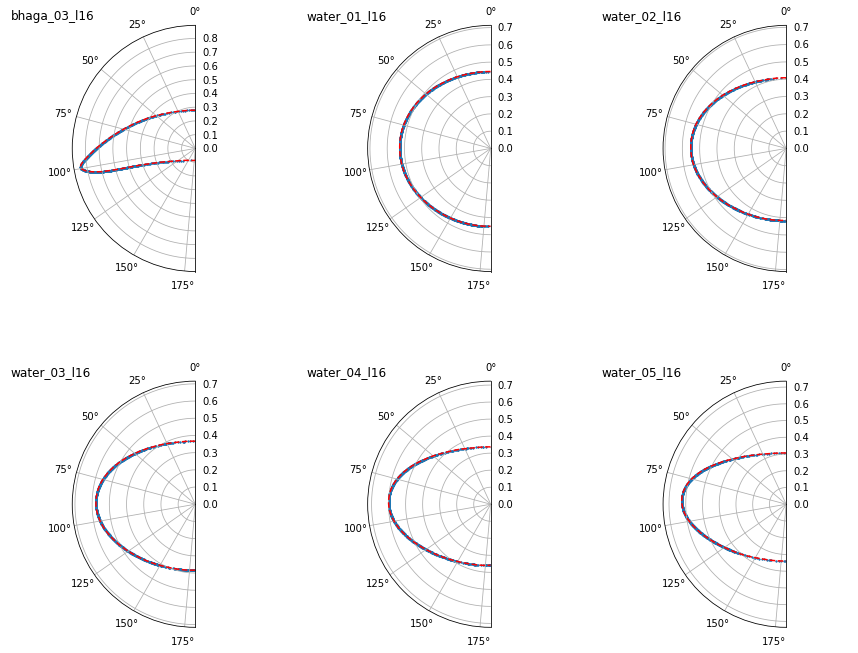

In [37]:
# show contour approximation
fig, axarr = plt.subplots(2, 3, figsize=(15, 12), subplot_kw=dict(projection='polar'))
ind = [(i, j) for i in range(axarr.shape[0]) for j in range(axarr.shape[1])]

for i, case in enumerate(shapes.keys()):
    px, py = shapes[case]
    radius, phi = polar_coordinates(py, px)
    # to evaluate the approximation, a much higher resolution can be used
    eval_phi = np.linspace(0.0, np.pi, 200)
    phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
    # load best weights and compute forward pass
    path = "./models/" + case + ".pt"
    model.load_state_dict(torch.load(path))
    model_radius = model.forward(phi_tensor).detach().squeeze().numpy()
    
    row, col = ind[i]
    axarr[row, col].scatter(phi, radius, s=1)
    axarr[row, col].plot(eval_phi, model_radius, c='r', linestyle='--')
    axarr[row, col].set_theta_zero_location("N")
    axarr[row, col].set_xlim(0.0, np.pi)
    axarr[row, col].set_title(case, loc='left')
    axarr[row, col].set_aspect('equal')

plt.savefig("simple_shapes.pdf", bbox_inches='tight')
plt.show()

## Export shapes as stl

In [38]:
# helper functions and structure
class Facet():
    def __init__(self, p1, p2, p3):
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
        
    def print_normal(self):
        normal = np.cross(self.p3-self.p1, self.p2-self.p1)
        normal = normal / np.linalg.norm(normal)
        return self.vec2str(normal)
        
    def print_points(self, pref):
        return pref + self.vec2str(self.p1) + '\n' + pref + self.vec2str(self.p2) + '\n' + pref + self.vec2str(self.p3) + '\n'
    
    @staticmethod
    def vec2str(vec):
        return str(vec[0]) + ' ' + str(vec[1]) + ' ' + str(vec[2])
    

def cartesian_coordinates(phi, radius):
    x = np.sin(phi) * radius
    y = np.cos(phi) * radius
    return x, y


def write_stl(path, name, facets):
    stl_file = open(path, 'w')
    stl_file.write("solid " + name + '\n')
    for facet in facets:
        stl_file.write("facet normal " + facet.print_normal() + "\n")
        stl_file.write("    outer loop\n")
        pref = ' ' * 8 + "vertex "
        stl_file.write(facet.print_points(pref))
        stl_file.write("    endloop\n")
        stl_file.write("endfacet\n")
    
    stl_file.write("endsolid " + name)
    stl_file.close()

In [39]:
height = 1.0
eval_phi = np.linspace(0.0, np.pi, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)

for case in shapes.keys():
    model = SimpleMLP(n_layers=6, n_neurons=40, activation=torch.sigmoid)
    model.load_state_dict(torch.load("./models/" + case + ".pt"))
    radius = model.forward(phi_tensor).detach().squeeze().numpy()
    x, y = cartesian_coordinates(eval_phi, radius)
    facet_list = []
    for i in range(len(x)-1):
        # upper triangle
        facet_list.append(Facet(np.asarray([x[i], y[i], 0.0]),
                                np.asarray([x[i+1], y[i+1], height]),
                                np.asarray([x[i], y[i], height]))
                        )
        # lower triangle
        facet_list.append(Facet(np.asarray([x[i], y[i], 0.0]),
                                np.asarray([x[i+1], y[i+1], 0.0]),
                                np.asarray([x[i+1], y[i+1], height]))
                         )
    path = "./" + case + ".stl"
    write_stl(path, case, facet_list)